# 📊 Predicción de Demanda Hotelera en Mendoza
## Tercera Entrega: Modelado y Evaluación

**Objetivo:** Desarrollar modelos predictivos para estimar la demanda turística en Mendoza
utilizando datos históricos de turismo, precios de dólar y variables temporales.

## 1. Definición del Problema y Objetivo Predictivo

### Objetivo Predictivo
**Problema:** Predecir el **número de turistas** que visitarán Mendoza en función de:
- Variables temporales (mes, año, temporada)
- País de origen y punto de entrada
- Precio del dólar (promedio, mínimo, máximo)
- Interés en Google
- Variables derivadas (temporada alta, vacaciones, etc.)

**Tipo de Problema:** **REGRESIÓN**
- Variable objetivo: `turistas` (variable continua numérica)
- Objetivo: Minimizar el error de predicción (RMSE, MAE)

**Justificación:** Este es un problema de regresión porque queremos predecir una cantidad
numérica continua (número de turistas). Esto permitirá a los hoteles planificar su capacidad,
personal y recursos de manera más efectiva.

In [9]:
# Instalar librerías necesarias
!pip install scikit-learn scipy joblib lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 2.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.4 MB/s  0:00:00


In [1]:
# %%
# =============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn - Modelado
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Estadística
from scipy import stats
from scipy.stats import shapiro

# Guardar modelo
import joblib

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("✅ LIBRERÍAS IMPORTADAS CORRECTAMENTE")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

✅ LIBRERÍAS IMPORTADAS CORRECTAMENTE
📅 Fecha de ejecución: 2025-10-21 13:59:16


✅ Archivo encontrado
✅ Dataset cargado correctamente con separador punto y coma

📊 INFORMACIÓN DEL DATASET
Dimensiones: 2,877 filas x 31 columnas

Primeras filas del dataset:
  indice_tiempo               pais_origen       punto_entrada  turistas  \
0       2014-01                    Brasil  Aeropuerto Córdoba       654   
1       2014-01                     Chile  Aeropuerto Córdoba      1046   
2       2014-01    Ee.Uu, Canadá Y México  Aeropuerto Córdoba      1211   
3       2014-01  Europa Y Resto Del Mundo  Aeropuerto Córdoba       719   
4       2014-01          Resto De América  Aeropuerto Córdoba       763   

   precio_promedio_usd  precio_minimo_usd  precio_maximo_usd  dias  \
0                  7.1                6.0                8.0    31   
1                  7.1                6.0                8.0    31   
2                  7.1                6.0                8.0    31   
3                  7.1                6.0                8.0    31   
4                  7.1  

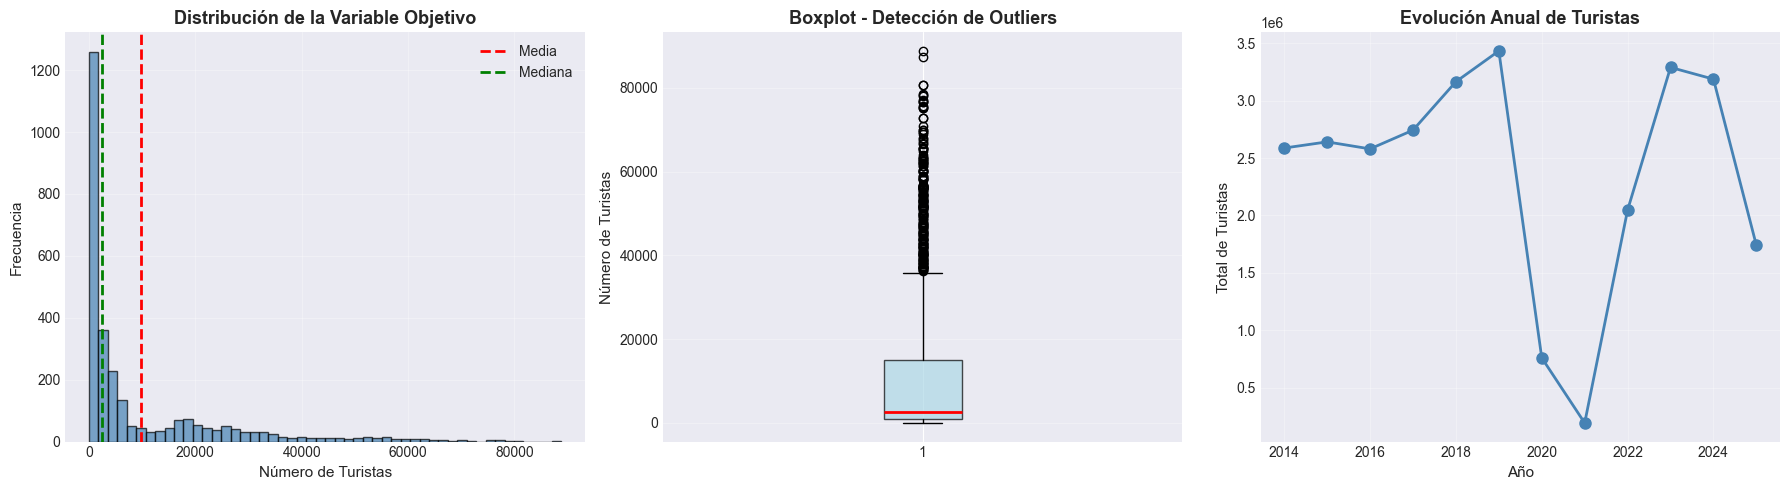


✅ EXPLORACIÓN INICIAL COMPLETADA


In [2]:
# =============================================================================
# CELDA 2: CARGA Y EXPLORACIÓN INICIAL DE DATOS
# =============================================================================

# Verificar que el archivo existe
import os
if not os.path.exists('mendoza_turismo_final_filtrado.csv'):
    print("❌ ERROR: El archivo 'mendoza_turismo_final_filtrado.csv' no existe en esta ubicación")
    print(f"📁 Archivos disponibles: {os.listdir('.')}")
else:
    print("✅ Archivo encontrado")

# Intentar cargar el dataset con diferentes configuraciones
try:
    df = pd.read_csv('mendoza_turismo_final_filtrado.csv', encoding='utf-8')
    print("✅ Dataset cargado correctamente con separador por defecto (coma)")
except:
    try:
        df = pd.read_csv('mendoza_turismo_final_filtrado.csv', sep=';', encoding='utf-8')
        print("✅ Dataset cargado correctamente con separador punto y coma")
    except:
        df = pd.read_csv('mendoza_turismo_final_filtrado.csv', 
                         encoding='utf-8', 
                         on_bad_lines='skip',
                         engine='python')
        print("⚠️ Dataset cargado omitiendo líneas problemáticas")

print("\n" + "="*80)
print("📊 INFORMACIÓN DEL DATASET")
print("="*80)
print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"\nPrimeras filas del dataset:")
print(df.head())

print("\n" + "-"*80)
print("Información de tipos de datos:")
df.info()

print("\n" + "-"*80)
print("📈 ESTADÍSTICAS DE LA VARIABLE OBJETIVO: 'turistas'")
print("="*80)
print(df['turistas'].describe())
print(f"\n✓ Media: {df['turistas'].mean():,.0f} turistas")
print(f"✓ Mediana: {df['turistas'].median():,.0f} turistas")
print(f"✓ Desv. Estándar: {df['turistas'].std():,.0f}")
print(f"✓ Valores nulos: {df['turistas'].isnull().sum()}")

# Verificar valores nulos en todo el dataset
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("\n✅ No hay valores nulos en el dataset")
else:
    print("\n⚠️ Valores nulos encontrados:")
    print(null_counts[null_counts > 0])

# ========== MEJORA 1: ELIMINAR COLUMNAS COMPLETAMENTE NULAS ==========
print("\n" + "="*80)
print("🔧 LIMPIEZA DE DATOS")
print("="*80)

# Identificar columnas completamente nulas
null_cols = df.columns[df.isnull().all()].tolist()
if null_cols:
    print(f"⚠️ Columnas completamente nulas detectadas: {null_cols}")
    df = df.drop(columns=null_cols)
    print(f"✅ Columnas eliminadas. Nuevo shape: {df.shape}")
else:
    print("✅ No hay columnas completamente nulas")

# ========== MEJORA 2: ANÁLISIS PROFUNDO DE DISTRIBUCIÓN ==========
print("\n" + "="*80)
print("📊 ANÁLISIS PROFUNDO DE DISTRIBUCIÓN")
print("="*80)

skewness = df['turistas'].skew()
kurtosis = df['turistas'].kurtosis()

print(f"   • Asimetría (Skewness): {skewness:.2f}")
if skewness > 1:
    print(f"     → Distribución MUY sesgada a la derecha (muchos valores bajos, pocos muy altos)")
elif skewness > 0.5:
    print(f"     → Distribución moderadamente sesgada a la derecha")
else:
    print(f"     → Distribución relativamente simétrica")

print(f"   • Curtosis (Kurtosis): {kurtosis:.2f}")
if kurtosis > 3:
    print(f"     → Distribución con colas pesadas (presencia de outliers)")
elif kurtosis < -1:
    print(f"     → Distribución con colas ligeras (pocos outliers)")
else:
    print(f"     → Distribución normal en cuanto a colas")

# Análisis de outliers
Q1 = df['turistas'].quantile(0.25)
Q3 = df['turistas'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (df['turistas'] < lower_bound) | (df['turistas'] > upper_bound)
outliers_count = outliers_mask.sum()

print(f"\n   • Rango Intercuartílico (IQR): {IQR:.0f}")
print(f"   • Límite inferior: {lower_bound:.0f}")
print(f"   • Límite superior: {upper_bound:.0f}")
print(f"   • Outliers detectados: {outliers_count} ({outliers_count/len(df)*100:.1f}%)")

# Mostrar ejemplos de outliers
if outliers_count > 0:
    print(f"\n   📌 Top 5 valores más altos (outliers):")
    print(df.nlargest(5, 'turistas')[['indice_tiempo', 'pais_origen', 'punto_entrada', 'turistas']])

# ========== MEJORA 3: ANÁLISIS TEMPORAL DETALLADO ==========
print("\n" + "="*80)
print("📅 ANÁLISIS TEMPORAL")
print("="*80)

turistas_por_anio_detalle = df.groupby('año')['turistas'].agg(['sum', 'mean', 'count']).reset_index()
turistas_por_anio_detalle.columns = ['Año', 'Total', 'Promedio', 'Registros']

print("\nResumen por año:")
print(turistas_por_anio_detalle.to_string(index=False))

# Identificar el año con caída más significativa
if len(turistas_por_anio_detalle) > 1:
    variacion = turistas_por_anio_detalle['Total'].pct_change() * 100
    if not variacion.isna().all():
        idx_min = variacion.idxmin()
        if not pd.isna(idx_min):
            año_mayor_caida = turistas_por_anio_detalle.loc[idx_min, 'Año']
            porcentaje_caida = variacion.min()
            print(f"\n⚠️ Mayor caída: Año {int(año_mayor_caida)} ({porcentaje_caida:.1f}% vs año anterior)")
            if año_mayor_caida == 2020:
                print(f"   → Probablemente debido a la pandemia COVID-19")

# Visualización de la variable objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(df['turistas'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['turistas'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
axes[0].axvline(df['turistas'].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
axes[0].set_xlabel('Número de Turistas', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de la Variable Objetivo', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(df['turistas'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Número de Turistas', fontsize=11)
axes[1].set_title('Boxplot - Detección de Outliers', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Evolución temporal
turistas_por_anio = df.groupby('año')['turistas'].sum().reset_index()
axes[2].plot(turistas_por_anio['año'], turistas_por_anio['turistas'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[2].set_xlabel('Año', fontsize=11)
axes[2].set_ylabel('Total de Turistas', fontsize=11)
axes[2].set_title('Evolución Anual de Turistas', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ EXPLORACIÓN INICIAL COMPLETADA")
print("="*80)

🔢 ANÁLISIS DE VARIABLES

Variables Numéricas (25):
['precio_promedio_usd', 'precio_minimo_usd', 'precio_maximo_usd', 'dias', 'variacion_usd_mensual', 'variacion_porcentual_usd', 'usd_alto', 'usd_alta_variabilidad', 'año', 'mes', 'es_enero', 'es_febrero', 'es_marzo', 'es_abril', 'es_mayo', 'es_junio', 'es_julio', 'es_agosto', 'es_septiembre', 'es_octubre', 'es_noviembre', 'es_diciembre', 'mes_vendimia', 'vacaciones_invierno', 'temporada_alta']

Variables Categóricas (3):
['indice_tiempo', 'pais_origen', 'punto_entrada']

📋 ANÁLISIS DE VARIABLES CATEGÓRICAS

indice_tiempo:
   • Valores únicos: 140
   • Top 5 valores más frecuentes:
      - 2019-05: 23 (0.8%)
      - 2019-06: 23 (0.8%)
      - 2019-07: 23 (0.8%)
      - 2019-08: 23 (0.8%)
      - 2020-01: 23 (0.8%)

pais_origen:
   • Valores únicos: 13
   • Top 5 valores más frecuentes:
      - Chile: 463 (16.1%)
      - Brasil: 373 (13.0%)
      - Resto Del Mundo: 367 (12.8%)
      - Uruguay: 277 (9.6%)
      - Europa Y Resto Del Mundo: 

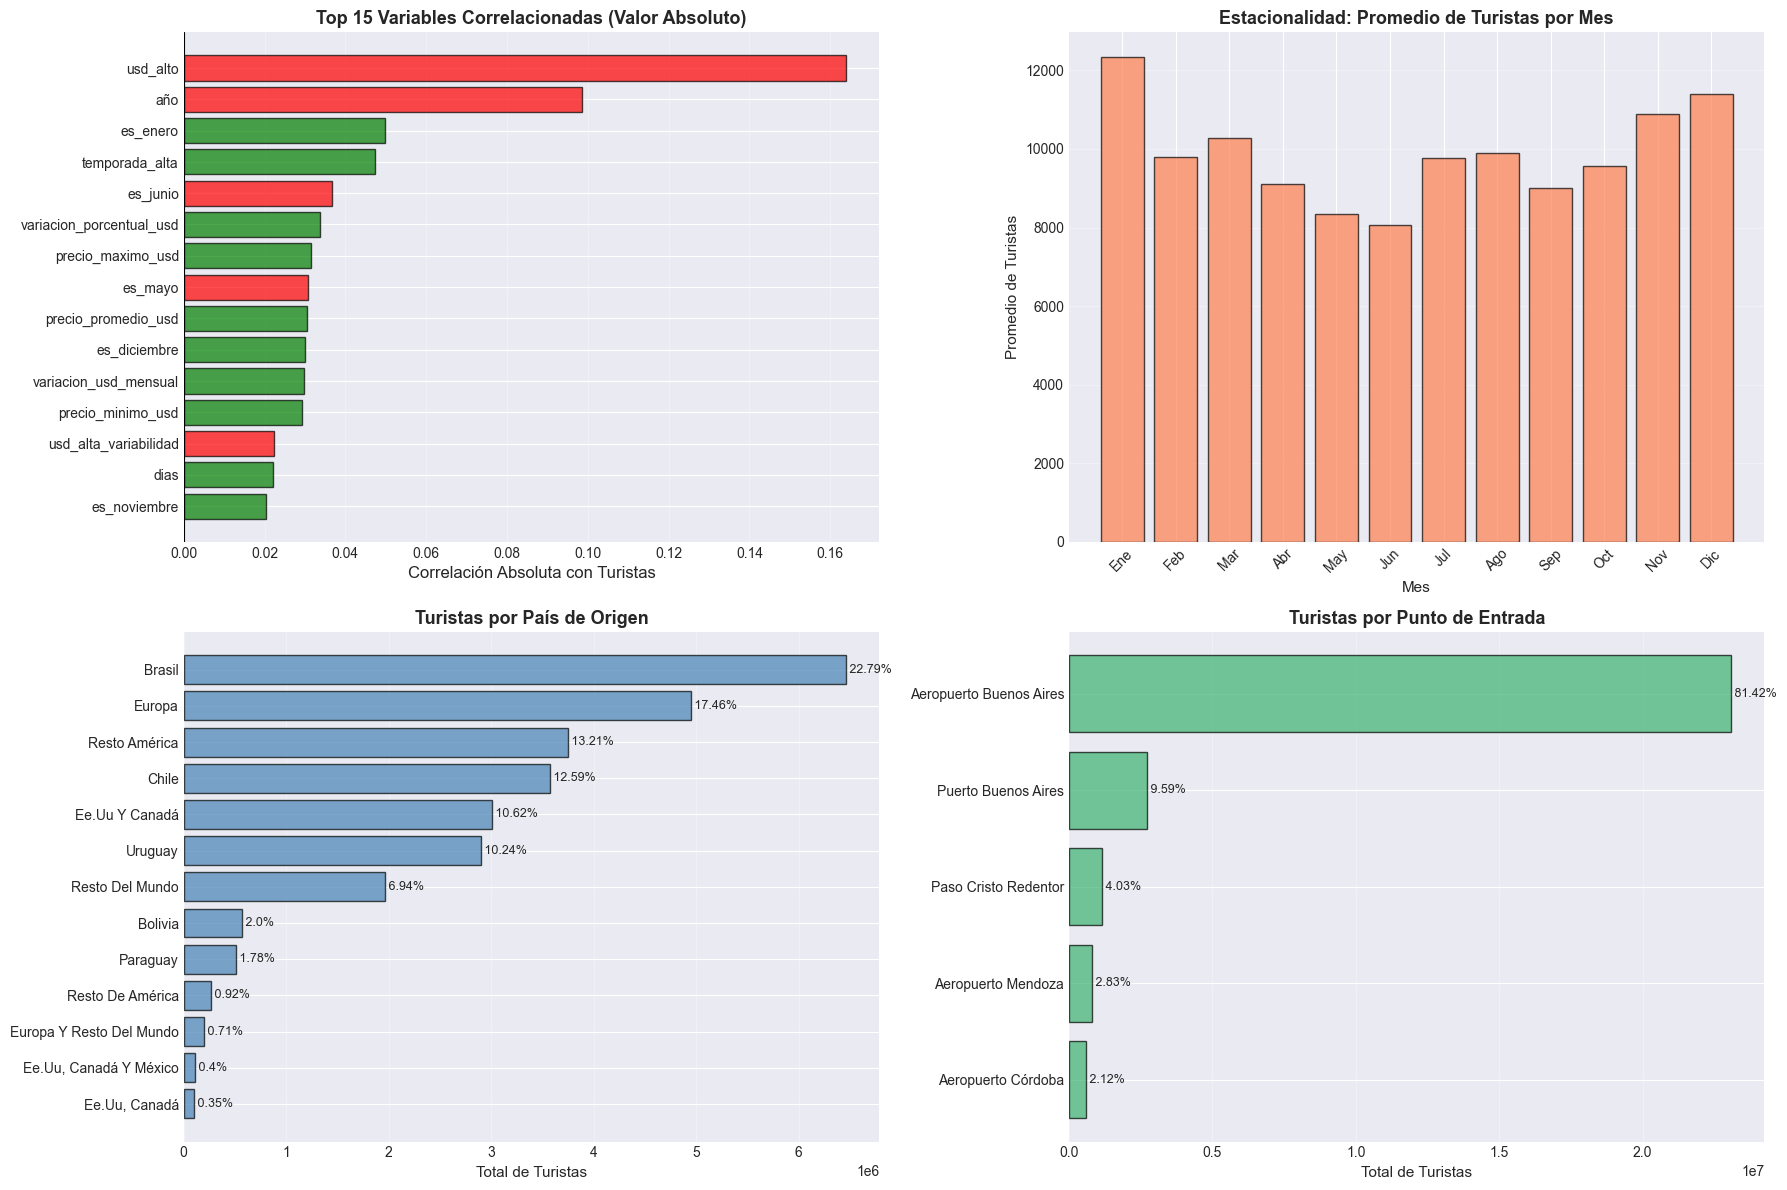


✅ ANÁLISIS DE VARIABLES COMPLETADO


In [3]:
# =============================================================================
# CELDA 3: ANÁLISIS DE VARIABLES Y CORRELACIONES
# =============================================================================

# Identificar tipos de variables
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remover la variable objetivo
if 'turistas' in numeric_features:
    numeric_features.remove('turistas')

print("="*80)
print("🔢 ANÁLISIS DE VARIABLES")
print("="*80)
print(f"\nVariables Numéricas ({len(numeric_features)}):")
print(numeric_features)
print(f"\nVariables Categóricas ({len(categorical_features)}):")
print(categorical_features)

# ========== MEJORA 1: ANÁLISIS DE VARIABLES CATEGÓRICAS ==========
print("\n" + "="*80)
print("📋 ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*80)

for cat_col in categorical_features:
    unique_count = df[cat_col].nunique()
    print(f"\n{cat_col}:")
    print(f"   • Valores únicos: {unique_count}")
    print(f"   • Top 5 valores más frecuentes:")
    top_values = df[cat_col].value_counts().head(5)
    for val, count in top_values.items():
        print(f"      - {val}: {count} ({count/len(df)*100:.1f}%)")

# ========== ANÁLISIS DE CORRELACIONES ==========
print("\n" + "="*80)
print("🔗 ANÁLISIS DE CORRELACIONES")
print("="*80)

correlations = df[numeric_features + ['turistas']].corr()['turistas'].sort_values(ascending=False)

print("\nTop 15 correlaciones POSITIVAS con 'turistas':")
positive_corr = correlations[correlations > 0].drop('turistas').head(15)
print(positive_corr)

print("\nTop 10 correlaciones NEGATIVAS con 'turistas':")
negative_corr = correlations[correlations < 0].tail(10)
print(negative_corr)

# ========== MEJORA 2: INTERPRETACIÓN DE CORRELACIONES ==========
print("\n" + "="*80)
print("💡 INTERPRETACIÓN DE CORRELACIONES")
print("="*80)

max_corr = correlations.drop('turistas').abs().max()
print(f"\n📊 Correlación máxima (en valor absoluto): {max_corr:.4f}")

if max_corr < 0.1:
    print("\n⚠️ HALLAZGO IMPORTANTE:")
    print("   • Las correlaciones lineales son MUY DÉBILES (< 0.1)")
    print("   • Esto sugiere que:")
    print("     1. Las relaciones son NO LINEALES")
    print("     2. Las interacciones entre variables son importantes")
    print("     3. Modelos de árboles (Random Forest, Gradient Boosting) serán MÁS efectivos")
    print("     4. Las variables categóricas probablemente tengan más peso")
elif max_corr < 0.3:
    print("\n📌 Correlaciones débiles (0.1 - 0.3)")
    print("   • Relaciones lineales limitadas")
    print("   • Se recomienda usar modelos no lineales")
elif max_corr < 0.5:
    print("\n📌 Correlaciones moderadas (0.3 - 0.5)")
    print("   • Hay relaciones lineales detectables")
else:
    print("\n✅ Correlaciones fuertes (> 0.5)")
    print("   • Relaciones lineales significativas")

# ========== MEJORA 3: ANÁLISIS POR PAÍS Y PUNTO DE ENTRADA ==========
print("\n" + "="*80)
print("🌍 ANÁLISIS POR PAÍS DE ORIGEN Y PUNTO DE ENTRADA")
print("="*80)

# Turistas por país
turistas_por_pais = df.groupby('pais_origen')['turistas'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
turistas_por_pais.columns = ['Total', 'Promedio', 'Registros']
turistas_por_pais['Porcentaje'] = (turistas_por_pais['Total'] / turistas_por_pais['Total'].sum() * 100).round(2)

print("\n📊 Turistas por País de Origen:")
print(turistas_por_pais.to_string())

# Turistas por punto de entrada
turistas_por_entrada = df.groupby('punto_entrada')['turistas'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
turistas_por_entrada.columns = ['Total', 'Promedio', 'Registros']
turistas_por_entrada['Porcentaje'] = (turistas_por_entrada['Total'] / turistas_por_entrada['Total'].sum() * 100).round(2)

print("\n🚪 Turistas por Punto de Entrada:")
print(turistas_por_entrada.to_string())

# ========== VISUALIZACIONES ==========
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Gráfico de barras de correlaciones
top_corr = correlations.drop('turistas').abs().sort_values(ascending=False).head(15)
colors = ['green' if correlations[idx] > 0 else 'red' for idx in top_corr.index]
axes[0, 0].barh(range(len(top_corr)), top_corr.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_corr)))
axes[0, 0].set_yticklabels(top_corr.index)
axes[0, 0].set_xlabel('Correlación Absoluta con Turistas', fontsize=12)
axes[0, 0].set_title('Top 15 Variables Correlacionadas (Valor Absoluto)', fontsize=13, fontweight='bold')
axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Turistas por mes (estacionalidad)
turistas_por_mes = df.groupby('mes')['turistas'].mean().reset_index()
axes[0, 1].bar(turistas_por_mes['mes'], turistas_por_mes['turistas'], 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Mes', fontsize=11)
axes[0, 1].set_ylabel('Promedio de Turistas', fontsize=11)
axes[0, 1].set_title('Estacionalidad: Promedio de Turistas por Mes', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Turistas por país
axes[1, 0].barh(range(len(turistas_por_pais)), turistas_por_pais['Total'], 
                color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(turistas_por_pais)))
axes[1, 0].set_yticklabels(turistas_por_pais.index)
axes[1, 0].set_xlabel('Total de Turistas', fontsize=11)
axes[1, 0].set_title('Turistas por País de Origen', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Agregar porcentajes
for i, (total, pct) in enumerate(zip(turistas_por_pais['Total'], turistas_por_pais['Porcentaje'])):
    axes[1, 0].text(total, i, f' {pct}%', va='center', fontsize=9)

# 4. Turistas por punto de entrada
axes[1, 1].barh(range(len(turistas_por_entrada)), turistas_por_entrada['Total'], 
                color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(turistas_por_entrada)))
axes[1, 1].set_yticklabels(turistas_por_entrada.index)
axes[1, 1].set_xlabel('Total de Turistas', fontsize=11)
axes[1, 1].set_title('Turistas por Punto de Entrada', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

# Agregar porcentajes
for i, (total, pct) in enumerate(zip(turistas_por_entrada['Total'], turistas_por_entrada['Porcentaje'])):
    axes[1, 1].text(total, i, f' {pct}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ ANÁLISIS DE VARIABLES COMPLETADO")
print("="*80)

In [4]:
# =============================================================================
# CELDA 4 (MEJORADA): PREPARACIÓN DE DATOS, DETECCIÓN DE PERIODOS EXTREMOS Y SPLIT
# =============================================================================

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("📂 PREPARACIÓN DE DATOS (Mejorada)")
print("="*80)

# Asumimos df ya cargado en memoria
print(f"✅ Dataset shape: {df.shape}")

# 1) Eliminar columnas completamente nulas (si existen)
null_cols = df.columns[df.isnull().all()].tolist()
if null_cols:
    print(f"⚠️ Columnas completamente nulas detectadas y eliminadas: {null_cols}")
    df = df.drop(columns=null_cols)
else:
    print("✅ No hay columnas completamente nulas")

# 2) Convertir 'indice_tiempo' a datetime si existe
if 'indice_tiempo' in df.columns:
    df['indice_tiempo_dt'] = pd.to_datetime(df['indice_tiempo'], errors='coerce')
    n_null_dt = df['indice_tiempo_dt'].isnull().sum()
    print(f"✅ 'indice_tiempo' -> datetime. Nulls en conversión: {n_null_dt}")
    # Crear año/mes si no existen
    if 'año' not in df.columns or 'mes' not in df.columns:
        df['año'] = df['indice_tiempo_dt'].dt.year.astype('Int64')
        df['mes'] = df['indice_tiempo_dt'].dt.month.astype('Int64')
        print("   → Columnas 'año' y 'mes' creadas")
else:
    print("ℹ️ 'indice_tiempo' no presente - no se puede hacer split temporal automáticamente")

# 3) Detectar meses con alta tasa de ceros (periodos extremos/pandemia)
if 'indice_tiempo_dt' in df.columns and df['indice_tiempo_dt'].notna().any():
    df['mes_ano'] = df['indice_tiempo_dt'].dt.to_period('M')
    zero_rate = df.groupby('mes_ano')['turistas'].apply(lambda s: (s==0).mean()).rename('zero_rate')
    zero_rate = zero_rate.reset_index()
    # Marcar meses con zero_rate > umbral (p.ex. 5% o adaptativo)
    umbral = 0.05
    meses_extremos = zero_rate[zero_rate['zero_rate'] > umbral]['mes_ano'].astype(str).tolist()
    print(f"\n🔎 Meses con tasa de ceros > {umbral*100:.1f}%: {len(meses_extremos)} meses detectados")
    if meses_extremos:
        print("   Ejemplos (hasta 10):", meses_extremos[:10])
    # Agregar columna indicadora al df
    df['es_periodo_extremo'] = df['mes_ano'].astype(str).isin(meses_extremos).astype(int)
else:
    df['es_periodo_extremo'] = 0
    print("\nℹ️ No hay fecha válida para detectar periodos extremos. 'es_periodo_extremo' = 0 para todos")

# 4) Información sobre registros con 0 turistas
zero_count = (df['turistas'] == 0).sum()
zero_pct = zero_count / len(df) * 100
print("\n" + "-"*60)
print(f"📊 Registros con 0 turistas: {zero_count} ({zero_pct:.2f}%)")
if zero_count > 0:
    print("   • Muestra (primeros 10 registros con 0):")
    display(df[df['turistas'] == 0].head(10))

# 5) Definir X e y y eliminar columnas redundantes antes del split (ej: indice_tiempo, mes_ano)
X = df.drop(columns=['turistas'])
y = df['turistas'].copy()

# Columnas a eliminar del entrenamiento (referencias temporales)
cols_drop = ['indice_tiempo', 'indice_tiempo_dt', 'mes_ano']
X = X.drop(columns=[c for c in cols_drop if c in X.columns], errors='ignore')

print("\n" + "-"*60)
print(f"✅ Variables predictoras (X): {X.shape}")
print(f"✅ Variable objetivo (y): {y.shape}")

# 6) Opciones de split (elige UNA): temporal_split=True para split por fecha, else stratified/random
temporal_split = True   # <-- CAMBIA a False para usar split aleatorio estratificado

if temporal_split and 'año' in df.columns and df['indice_tiempo_dt'].notna().any():
    # Split temporal dinámico: elegir cutoff que aprox 80% de filas en train
    df_sorted = df.sort_values('indice_tiempo_dt').reset_index(drop=True)
    total = len(df_sorted)
    # escoger el índice de corte
    cut_idx = int(total * 0.8)
    cutoff_date = df_sorted.loc[cut_idx, 'indice_tiempo_dt']
    print(f"\n🔀 Split temporal seleccionado: cutoff = {cutoff_date.date()} (≈80% train)")
    train_mask = df['indice_tiempo_dt'] <= cutoff_date
    test_mask = df['indice_tiempo_dt'] > cutoff_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    split_type = 'temporal'
else:
    # Split aleatorio estratificado por bins del target (mantiene representatividad en colas)
    print("\n🔀 Split aleatorio estratificado por bins del target (fallback)")
    # crear bins usando quantiles
    n_bins = 10
    y_binned = pd.qcut(y.rank(method='first'), q=n_bins, labels=False, duplicates='drop')
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_binned
    )
    split_type = 'estratificado'

print(f"\n✓ Tipo de split usado: {split_type}")
print(f"✓ Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Test : {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.1f}%)")

# 7) Estadísticas del target por split
def stats_target(s):
    return {
        'count': int(len(s)),
        'mean': float(s.mean()),
        'std': float(s.std()),
        'min': float(s.min()),
        'p25': float(s.quantile(0.25)),
        'p50': float(s.median()),
        'p75': float(s.quantile(0.75)),
        'p90': float(s.quantile(0.90)),
        'p95': float(s.quantile(0.95)),
        'p99': float(s.quantile(0.99)),
        'max': float(s.max())
    }

print("\n" + "-"*60)
print("📊 Estadísticas del target por split:")
print("Train:", stats_target(y_train))
print("Test :", stats_target(y_test))

# 8) Mostrar percentiles extremos y ver representatividad
print("\n" + "-"*60)
print("📊 Percentiles extremos (Train vs Test):")
for p in [0.90, 0.95, 0.99]:
    print(f"P{int(p*100)} - Train: {y_train.quantile(p):,.0f} | Test: {y_test.quantile(p):,.0f} | Diff: {y_test.quantile(p)-y_train.quantile(p):,.0f}")

# 9) Opción: crear target transformado log1p para experimentos posteriores (recomendado)
do_log = True   # <-- Cambiar a False si no quieres crear
if do_log:
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)
    print("\nℹ️ Se creó target transformado: y_train_log / y_test_log (log1p). Útil para mitigar heterocedasticidad.")

# 10) Resumen sobre registros con 0 en Train/Test y en periodo extremo
zero_train = (y_train == 0).sum()
zero_test = (y_test == 0).sum()
print("\n" + "-"*60)
print("📊 Registros con 0 turistas por split:")
print(f"   • Train: {zero_train} ({zero_train/len(y_train)*100:.2f}%)")
print(f"   • Test : {zero_test} ({zero_test/len(y_test)*100:.2f}%)")

# 11) Guardar variables para próximas celdas
# (Asegúrate de que X_train/X_test tengan las mismas columnas que el pipeline esperará)
X_train = X_train.copy()
X_test = X_test.copy()

print("\n" + "="*80)
print("✅ PREPARACIÓN DE DATOS COMPLETADA (CELDA 4 Mejorada)")
print("="*80)


📂 PREPARACIÓN DE DATOS (Mejorada)
✅ Dataset shape: (2877, 29)
✅ No hay columnas completamente nulas
✅ 'indice_tiempo' -> datetime. Nulls en conversión: 0

🔎 Meses con tasa de ceros > 5.0%: 18 meses detectados
   Ejemplos (hasta 10): ['2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01']

------------------------------------------------------------
📊 Registros con 0 turistas: 389 (13.52%)
   • Muestra (primeros 10 registros con 0):


,indice_tiempo,pais_origen,punto_entrada,turistas,precio_promedio_usd,precio_minimo_usd,precio_maximo_usd,dias,variacion_usd_mensual,variacion_porcentual_usd,...,es_septiembre,es_octubre,es_noviembre,es_diciembre,mes_vendimia,vacaciones_invierno,temporada_alta,indice_tiempo_dt,mes_ano,es_periodo_extremo
1410,2020-04,Bolivia,Aeropuerto Buenos Aires,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1411,2020-04,Brasil,Aeropuerto Buenos Aires,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1412,2020-04,Brasil,Aeropuerto Córdoba,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1413,2020-04,Brasil,Aeropuerto Mendoza,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1414,2020-04,Chile,Aeropuerto Buenos Aires,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1415,2020-04,Chile,Aeropuerto Córdoba,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1416,2020-04,Chile,Aeropuerto Mendoza,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1417,2020-04,Chile,Paso Cristo Redentor,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1418,2020-04,Ee.Uu Y Canadá,Aeropuerto Buenos Aires,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1
1419,2020-04,"Ee.Uu, Canadá",Aeropuerto Mendoza,0,67.8,67.0,69.0,30,2.0,2.99,...,0,0,0,0,0,0,0,2020-04-01,2020-04,1



------------------------------------------------------------
✅ Variables predictoras (X): (2877, 28)
✅ Variable objetivo (y): (2877,)

🔀 Split temporal seleccionado: cutoff = 2023-06-01 (≈80% train)

✓ Tipo de split usado: temporal
✓ Train: 2,307 registros (80.2%)
✓ Test : 570 registros (19.8%)

------------------------------------------------------------
📊 Estadísticas del target por split:
Train: {'count': 2307, 'mean': 9417.7837017772, 'std': 14648.913625495503, 'min': 0.0, 'p25': 719.0, 'p50': 2011.0, 'p75': 14438.0, 'p90': 29047.4, 'p95': 41716.7, 'p99': 63983.98000000003, 'max': 88814.0}
Test : {'count': 570, 'mean': 11639.078947368422, 'std': 16560.855831204684, 'min': 344.0, 'p25': 1600.0, 'p50': 3614.0, 'p75': 16399.5, 'p90': 37308.5, 'p95': 51300.2, 'p99': 73473.49999999987, 'max': 87279.0}

------------------------------------------------------------
📊 Percentiles extremos (Train vs Test):
P90 - Train: 29,047 | Test: 37,308 | Diff: 8,261
P95 - Train: 41,717 | Test: 51,300 |

In [5]:
# =============================================================================
# CELDA 5 (MEJORADA): CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO
# =============================================================================

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("🔧 CONSTRUCCIÓN DEL PIPELINE DE SCIKIT-LEARN (MEJORADO)")
print("="*80)

# Asegurarse de que la columna es_periodo_extremo exista
if 'es_periodo_extremo' not in X.columns:
    X['es_periodo_extremo'] = 0
    print("ℹ️ Se añadió 'es_periodo_extremo' con valores 0 (no detectado)")

# Lista de features: actualizar según salida de la celda 4
# Eliminamos 'mes' numérico porque ya tenemos dummies es_enero...es_diciembre
drop_if_present = ['mes']
for c in drop_if_present:
    if c in X.columns:
        X = X.drop(columns=[c])
        print(f"ℹ️ Eliminada columna redundante: {c}")

# Definir listas de features actualizadas
numeric_features = [
    'precio_promedio_usd', 'precio_minimo_usd', 'precio_maximo_usd',
    'dias', 'variacion_usd_mensual', 'variacion_porcentual_usd',
    'usd_alto', 'usd_alta_variabilidad', 'año',
    # flags mensuales ya están en dummies (es_enero ... es_diciembre)
    'es_enero','es_febrero','es_marzo','es_abril','es_mayo',
    'es_junio','es_julio','es_agosto','es_septiembre','es_octubre',
    'es_noviembre','es_diciembre',
    'mes_vendimia','vacaciones_invierno','temporada_alta',
    'es_periodo_extremo'   # <-- importante: incluir
]

# Mantener sólo las columnas que efectivamente existen (por seguridad)
numeric_features = [c for c in numeric_features if c in X.columns]

categorical_features = [c for c in ['pais_origen', 'punto_entrada'] if c in X.columns]

print(f"\n📊 Variables Numéricas ({len(numeric_features)}):")
for i in range(0, len(numeric_features), 6):
    print("  ", numeric_features[i:i+6])

print(f"\n📋 Variables Categóricas ({len(categorical_features)}): {categorical_features}")

# ========== TRANSFORMADORES ==========
# Numéricas: imputación + RobustScaler (menos sensible a outliers)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Categóricas: imputación constante + OneHot (handle_unknown ignore)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer combinando
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'  # cualquier columna no listada será descartada
)

print("\n✅ PREPROCESSOR construido con RobustScaler y One-Hot (handle_unknown='ignore').")

# ========== PIPELINE COMPLETO (sin modelo) ==========
from sklearn.pipeline import make_pipeline
# Nota: en celda de entrenamiento añadirás ('model', estimator) al pipeline final.

# ========== ESTIMACIÓN DE DIMENSIONALIDAD (post-encoding estimada) ==========
n_numeric = len(numeric_features)
n_cat_encoded = sum([X[cat].nunique() for cat in categorical_features])
n_total = n_numeric + n_cat_encoded

print("\n" + "="*80)
print("📊 DIMENSIONALIDAD FINAL ESTIMADA (MEJORADA)")
print("="*80)
print(f"  • Variables numéricas: {n_numeric}")
print(f"  • Variables categóricas (antes encoding): {len(categorical_features)}")
print(f"  • Variables categóricas (después One-Hot estimadas): {n_cat_encoded}")
print(f"  • TOTAL de features estimado: {n_total}")

if n_total > 100:
    print("   ⚠️ Alta dimensionalidad (>=100), considerar encoding alternativo")
elif n_total > 50:
    print("   📊 Dimensionalidad moderada")
else:
    print("   ✅ Dimensionalidad baja/moderada — OK para RandomForest y GBM")

# ========== HELPER: función para extraer nombres de features tras fit ==========
def get_feature_names_after_preprocessing(preprocessor, numeric_feats, categorical_feats):
    # Debe llamarse después de preprocessor.fit(...)
    # Numeric names se mantienen en orden
    numeric_names = numeric_feats
    cat_transformer = preprocessor.named_transformers_['cat']
    # Obtener nombres generados por OneHotEncoder
    try:
        ohe = cat_transformer.named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_feats).tolist()
    except Exception:
        cat_names = []
    return numeric_names + cat_names

print("\n" + "="*80)
print("✅ PIPELINE DE PREPROCESAMIENTO (MEJORADO) LISTO")
print("   - Asegúrate de usar este 'preprocessor' en el Pipeline final antes del modelo")
print("   - Para extracción de feature names: llamar get_feature_names_after_preprocessing(preprocessor, numeric_features, categorical_features) DESPUÉS de fit")
print("="*80)


🔧 CONSTRUCCIÓN DEL PIPELINE DE SCIKIT-LEARN (MEJORADO)
ℹ️ Eliminada columna redundante: mes

📊 Variables Numéricas (25):
   ['precio_promedio_usd', 'precio_minimo_usd', 'precio_maximo_usd', 'dias', 'variacion_usd_mensual', 'variacion_porcentual_usd']
   ['usd_alto', 'usd_alta_variabilidad', 'año', 'es_enero', 'es_febrero', 'es_marzo']
   ['es_abril', 'es_mayo', 'es_junio', 'es_julio', 'es_agosto', 'es_septiembre']
   ['es_octubre', 'es_noviembre', 'es_diciembre', 'mes_vendimia', 'vacaciones_invierno', 'temporada_alta']
   ['es_periodo_extremo']

📋 Variables Categóricas (2): ['pais_origen', 'punto_entrada']

✅ PREPROCESSOR construido con RobustScaler y One-Hot (handle_unknown='ignore').

📊 DIMENSIONALIDAD FINAL ESTIMADA (MEJORADA)
  • Variables numéricas: 25
  • Variables categóricas (antes encoding): 2
  • Variables categóricas (después One-Hot estimadas): 18
  • TOTAL de features estimado: 43
   ✅ Dimensionalidad baja/moderada — OK para RandomForest y GBM

✅ PIPELINE DE PREPROCESAMIE

In [10]:
# =============================================================================
# CELDA 6 REVISADA: ENTRENAMIENTO Y DIAGNÓSTICO AVANZADO
# - Diagnóstico por fold (fechas + stats)
# - TransformedTargetRegressor (log1p) por defecto
# - RandomForest + LightGBM (con RandomizedSearch para RF)
# - Métricas robustas (MAE, RMSE, RMSE sin top1%, P90 error)
# =============================================================================

import time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# -------- CONFIGURACIÓN (ajusta según necesites) --------
n_splits = 5
use_log_transform = True           # PROBAR con True (recomendado). Cambia a False si quieres comparar.
weight_extreme_value = 0.3         # peso para es_periodo_extremo (0..1)
do_random_search = True
n_iter_search = 40
random_state = 42
verbose = 1
# -------------------------------------------------------

print("\n" + "="*80)
print("CELDA 6 REVISADA - Entrenamiento, diagnóstico por fold y búsqueda")
print("="*80)

# comprobaciones
for name in ['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test']:
    if name not in globals():
        raise RuntimeError(f"Falta variable: {name} en el entorno. Ejecuta celdas previas.")

# convertir índices y asegurarse dt existe
if 'indice_tiempo_dt' not in X_train.columns and 'indice_tiempo_dt' in globals().get('df', pd.DataFrame()).columns:
    X_train['indice_tiempo_dt'] = df.loc[X_train.index, 'indice_tiempo_dt']
if 'indice_tiempo_dt' not in X_train.columns:
    print("ℹ️ Nota: 'indice_tiempo_dt' no está en X_train; los diagnósticos por fecha serán limitados.")

# preparación TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# preparar sample weights
if 'es_periodo_extremo' in X_train.columns:
    weights_train = np.where(X_train['es_periodo_extremo'].astype(int) == 1, weight_extreme_value, 1.0)
    print(f"✅ sample_weight listo (es_periodo_extremo downweight={weight_extreme_value})")
else:
    weights_train = np.ones(len(X_train))
    print("ℹ️ es_periodo_extremo no en X_train -> pesos uniformes")

# modelos base a evaluar (RF y LightGBM serán el foco)
rf_base = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
lgb_base = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=random_state)

# helper: evaluar un estimador con TimeSeriesSplit y devolver métricas por fold y print de diagnóstico
def evaluate_model_tscv(base_model, X, y, weights=None, use_log=True, print_folds=True):
    fold_metrics = []
    fold_details = []
    for i, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        # fechas si existen
        start_train = X_tr['indice_tiempo_dt'].min() if 'indice_tiempo_dt' in X_tr.columns else None
        end_train = X_tr['indice_tiempo_dt'].max() if 'indice_tiempo_dt' in X_tr.columns else None
        start_val = X_val['indice_tiempo_dt'].min() if 'indice_tiempo_dt' in X_val.columns else None
        end_val = X_val['indice_tiempo_dt'].max() if 'indice_tiempo_dt' in X_val.columns else None
        # wrapper log if requested
        if use_log:
            model_wrap = TransformedTargetRegressor(regressor=base_model, func=np.log1p, inverse_func=np.expm1)
        else:
            model_wrap = base_model
        pipe = Pipeline([('preprocessor', preprocessor), ('model', model_wrap)])
        if weights is not None:
            w_tr = weights[tr_idx]
            pipe.fit(X_tr, y_tr, model__sample_weight=w_tr)
        else:
            pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        # robust metrics: RMSE excluding top 1% of absolute errors
        abs_err = np.abs(y_val - y_pred)
        cutoff = np.percentile(abs_err, 99)
        mask = abs_err <= cutoff
        rmse_no_top1 = np.sqrt(mean_squared_error(y_val[mask], y_pred[mask])) if mask.sum() > 5 else np.nan
        p90_err = np.percentile(abs_err, 90)
        fold_metrics.append({'rmse': rmse, 'mae': mae, 'r2': r2, 'rmse_no_top1': rmse_no_top1, 'p90_err': p90_err})
        fold_details.append({'fold': i, 'train_range': (start_train, end_train), 'val_range': (start_val, end_val),
                             'y_train_stats': y_tr.describe().to_dict(), 'y_val_stats': y_val.describe().to_dict()})
        if print_folds:
            print(f" Fold {i}: Train {start_train}→{end_train} | Val {start_val}→{end_val}")
            print(f"   y_train: mean={y_tr.mean():.1f} p90={y_tr.quantile(0.9):.0f} | y_val: mean={y_val.mean():.1f} p90={y_val.quantile(0.9):.0f}")
            print(f"   RMSE={rmse:,.2f} | MAE={mae:,.2f} | R2={r2:.4f} | RMSE_no_top1={rmse_no_top1:,.2f} | P90error={p90_err:,.0f}")
    return fold_metrics, fold_details

# 1) Diagnóstico: inspeccionar folds con un modelo ligero (RF con pocos árboles) para ver drift
print("\n>>> DIAGNÓSTICO DE FOLDS (RF rápido, log1p={})".format(use_log_transform))
_ = evaluate_model_tscv(RandomForestRegressor(n_estimators=40, random_state=random_state, n_jobs=-1),
                       X_train, y_train, weights=weights_train, use_log=use_log_transform, print_folds=True)

# 2) Entrenamiento final de modelos (RF y LightGBM) con log1p por defecto
print("\n>>> ENTRENAMIENTO FINAL: RandomForest y LightGBM (con log1p={})".format(use_log_transform))
def fit_and_eval(base_model, X_tr, y_tr, X_te, y_te, weights=None, use_log=True, name='model'):
    if use_log:
        model_wrap = TransformedTargetRegressor(regressor=base_model, func=np.log1p, inverse_func=np.expm1)
    else:
        model_wrap = base_model
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model_wrap)])
    pipe.fit(X_tr, y_tr, model__sample_weight=weights)
    y_tr_pred = pipe.predict(X_tr)
    y_te_pred = pipe.predict(X_te)
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_tr, y_tr_pred)),
        'train_mae': mean_absolute_error(y_tr, y_tr_pred),
        'train_r2': r2_score(y_tr, y_tr_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_te, y_te_pred)),
        'test_mae': mean_absolute_error(y_te, y_te_pred),
        'test_r2': r2_score(y_te, y_te_pred),
        'y_train_pred': y_tr_pred,
        'y_test_pred': y_te_pred,
        'pipeline': pipe
    }
    return metrics

rf_metrics = fit_and_eval(RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1),
                          X_train, y_train, X_test, y_test, weights=weights_train, use_log=use_log_transform, name='RandomForest_basic')

lgb_metrics = fit_and_eval(lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=random_state),
                           X_train, y_train, X_test, y_test, weights=weights_train, use_log=use_log_transform, name='LightGBM_basic')

print("\n RandomForest (basic) -> Test RMSE: {test_rmse:,.2f} | R2: {test_r2:.4f}".format(**rf_metrics))
print(" LightGBM    (basic) -> Test RMSE: {test_rmse:,.2f} | R2: {test_r2:.4f}".format(**lgb_metrics))

# 3) RandomizedSearchCV para RF (solo si do_random_search True)
rscv_results = None
if do_random_search:
    print("\n>>> RandomizedSearchCV para RandomForest (buscando regularización)")
    from sklearn.model_selection import RandomizedSearchCV
    rf_pipe = Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=random_state, n_jobs=-1))])
    param_dist = {
        'model__n_estimators': [200, 400, 800],
        'model__max_depth': [None, 20, 30, 50],
        'model__min_samples_split': [2, 5, 10, 20, 50],
        'model__min_samples_leaf': [1, 2, 4, 8, 20],
        'model__max_features': ['sqrt', 0.5, 0.33]
    }
    rscv = RandomizedSearchCV(rf_pipe, param_distributions=param_dist, n_iter=n_iter_search,
                              cv=tscv, scoring='neg_root_mean_squared_error', random_state=random_state,
                              n_jobs=-1, verbose=2, return_train_score=True)
    rscv.fit(X_train, y_train, model__sample_weight=weights_train)
    rscv_results = {
        'best_estimator': rscv.best_estimator_,
        'best_params': rscv.best_params_,
        'best_cv_rmse': -rscv.best_score_
    }
    print("RandomSearch finalizado. Mejor CV RMSE:", rscv_results['best_cv_rmse'])
    print("Mejores params:", rscv_results['best_params'])

    # evaluar en test
    y_test_pred_rscv = rscv.best_estimator_.predict(X_test)
    test_rmse_rscv = np.sqrt(mean_squared_error(y_test, y_test_pred_rscv))
    print("Test RMSE (best RF):", test_rmse_rscv)

# 4) Comparativa y métricas robustas
summary = []
# incluir rf basic, lgb basic, y rscv si existe
for name, met in [('RandomForest_basic', rf_metrics), ('LightGBM_basic', lgb_metrics)]:
    summary.append({
        'Modelo': name,
        'Test RMSE': met['test_rmse'],
        'Test MAE': met['test_mae'],
        'Test R2': met['test_r2']
    })
if rscv_results is not None:
    # evaluar rscv best estimator pipeline
    y_tr_pred_rscv = rscv_results['best_estimator'].predict(X_train)
    y_te_pred_rscv = rscv_results['best_estimator'].predict(X_test)
    summary.append({
        'Modelo': 'RandomForest_optimized',
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_te_pred_rscv)),
        'Test MAE': mean_absolute_error(y_test, y_te_pred_rscv),
        'Test R2': r2_score(y_test, y_te_pred_rscv)
    })

summary_df = pd.DataFrame(summary).sort_values('Test RMSE').reset_index(drop=True)
print("\n" + "="*80)
print("Comparativa final (ordenada por Test RMSE):")
print(summary_df.to_string(index=False))
print("="*80)

# Guardar outputs para celdas siguientes
best_pipeline_final = None
if rscv_results is not None:
    best_pipeline_final = rscv_results['best_estimator']
    best_name = 'RandomForest_optimized'
else:
    # escoger el mejor entre rf_basic y lgb_basic por Test RMSE
    best_name = summary_df.loc[0, 'Modelo']
    best_pipeline_final = rf_metrics['pipeline'] if best_name == 'RandomForest_basic' else lgb_metrics['pipeline']

final_metrics = {
    'train_rmse': rf_metrics['train_rmse'] if best_name=='RandomForest_basic' else lgb_metrics['train_rmse'],
    'test_rmse': rf_metrics['test_rmse'] if best_name=='RandomForest_basic' else lgb_metrics['test_rmse'],
    'train_mae': rf_metrics['train_mae'] if best_name=='RandomForest_basic' else lgb_metrics['train_mae'],
    'test_mae': rf_metrics['test_mae'] if best_name=='RandomForest_basic' else lgb_metrics['test_mae'],
    'train_r2': rf_metrics['train_r2'] if best_name=='RandomForest_basic' else lgb_metrics['train_r2'],
    'test_r2': rf_metrics['test_r2'] if best_name=='RandomForest_basic' else lgb_metrics['test_r2'],
    'y_train_pred': rf_metrics['y_train_pred'] if best_name=='RandomForest_basic' else lgb_metrics['y_train_pred'],
    'y_test_pred': rf_metrics['y_test_pred'] if best_name=='RandomForest_basic' else lgb_metrics['y_test_pred'],
    'best_name': best_name
}

print("\n✅ CELDA 6 REVISADA COMPLETADA. Salidas: summary_df, rscv_results (si se ejecutó), best_pipeline_final, final_metrics.")


CELDA 6 REVISADA - Entrenamiento, diagnóstico por fold y búsqueda
✅ sample_weight listo (es_periodo_extremo downweight=0.3)

>>> DIAGNÓSTICO DE FOLDS (RF rápido, log1p=True)
 Fold 1: Train 2014-01-01 00:00:00→2016-01-01 00:00:00 | Val 2016-01-01 00:00:00→2017-12-01 00:00:00
   y_train: mean=14049.9 p90=37075 | y_val: mean=12743.1 p90=33230
   RMSE=6,959.71 | MAE=3,385.34 | R2=0.7995 | RMSE_no_top1=5,842.17 | P90error=12,180
 Fold 2: Train 2014-01-01 00:00:00→2017-12-01 00:00:00 | Val 2017-12-01 00:00:00→2019-04-01 00:00:00
   y_train: mean=13399.0 p90=34811 | y_val: mean=11832.2 p90=32895
   RMSE=4,054.46 | MAE=2,086.27 | R2=0.9358 | RMSE_no_top1=3,463.18 | P90error=5,698
 Fold 3: Train 2014-01-01 00:00:00→2019-04-01 00:00:00 | Val 2019-04-01 00:00:00→2020-09-01 00:00:00
   y_train: mean=12878.1 p90=34081 | y_val: mean=7893.2 p90=23618
   RMSE=11,615.93 | MAE=4,996.10 | R2=0.3747 | RMSE_no_top1=9,622.18 | P90error=15,188
 Fold 4: Train 2014-01-01 00:00:00→2020-09-01 00:00:00 | Val 202


📊 TABLA COMPARATIVA DE MODELOS
           Modelo     CV RMSE      CV Std  Train RMSE   Train MAE  Train R²   Test RMSE    Test MAE  Test R²  Overfitting
    Random Forest 3940.231335 1030.111502 1122.482712  485.808844  0.994311 3041.049059 1315.586042 0.962871 -1918.566347
Gradient Boosting 5484.073348  246.018432 4850.057517 2925.073953  0.893785 5501.123173 3225.427227 0.878504  -651.065656
Linear Regression 9119.013655  341.341551 8938.831759 6128.450190  0.639212 9238.242794 6145.745491 0.657359  -299.411034
 Ridge Regression 9119.772426  331.472931 8942.868643 6110.566767  0.638886 9271.452205 6138.221863 0.654891  -328.583563


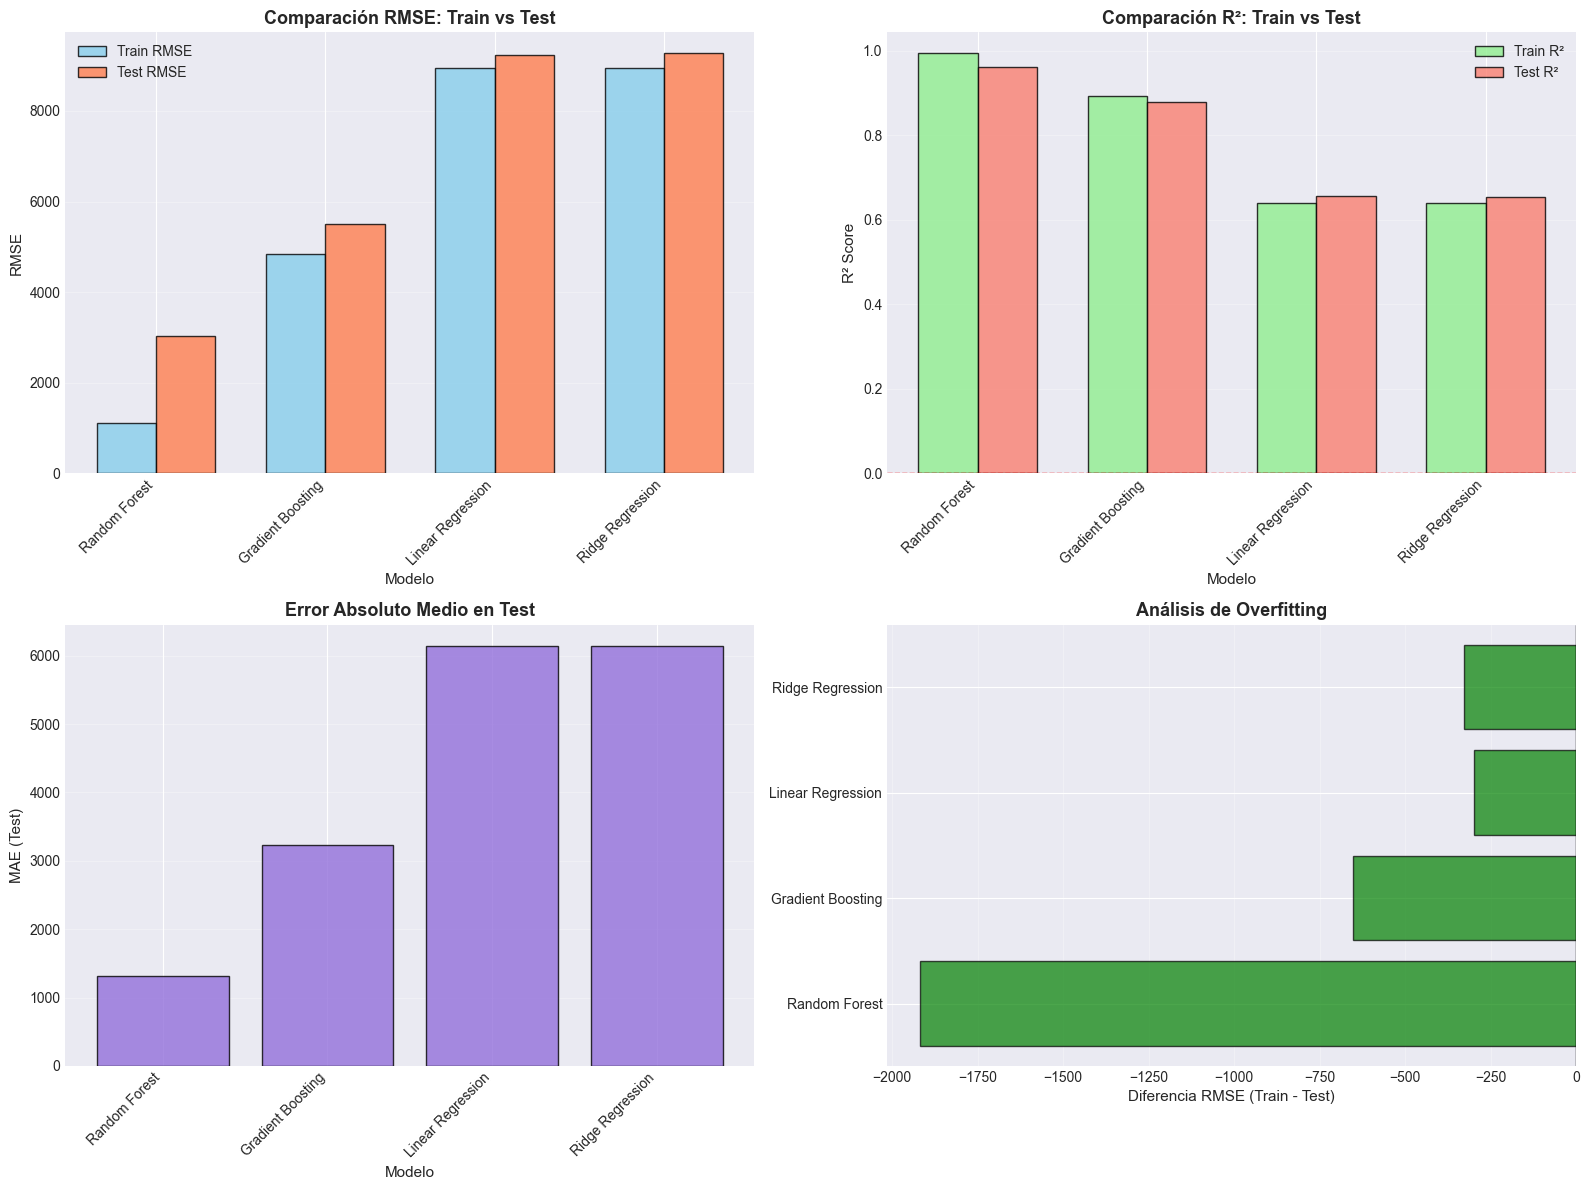


🏆 MEJOR MODELO SELECCIONADO
Modelo: Random Forest

📊 Métricas:
   • Test RMSE: 3,041.05
   • Test MAE: 1,315.59
   • Test R²: 0.9629
   • CV RMSE: 3,940.23 (±1,030.11)

🎯 Interpretación:
   El modelo explica el 96.29% de la variabilidad de los turistas

🔍 ANÁLISIS CRÍTICO DEL MODELO SELECCIONADO

📊 Métricas de Overfitting:
   • Train RMSE: 1,122.48
   • Test RMSE: 3,041.05
   • CV RMSE: 3,940.23
   • Ratio Test/Train RMSE: 2.71x
   • Diferencia porcentual RMSE: 63.1%
   • Diferencia R² (Train - Test): 0.0314

🎯 DIAGNÓSTICO:
   🚨 OVERFITTING SEVERO DETECTADO
   • El modelo es 2.7x PEOR en test que en train
   • Train RMSE = 1,122 vs Test RMSE = 3,041
   • Está memorizando los datos de entrenamiento

📊 Análisis de Estabilidad:
   • CV RMSE: 3,940.23 ± 1,030.11
   • Coeficiente de Variación: 26.1%
   ⚠️ Alta variabilidad en validación cruzada
   → El modelo es INESTABLE entre folds

📊 Coherencia CV vs Test:
   • Diferencia CV-Test: 899.18 (22.8%)
   ⚠️ CV y Test muy diferentes → Posible 

In [24]:
# =============================================================================
# CELDA 7: COMPARACIÓN Y VISUALIZACIÓN DE MODELOS
# =============================================================================

# Crear DataFrame de comparación
comparison_df = pd.DataFrame([
    {
        'Modelo': r['model_name'],
        'CV RMSE': r['cv_rmse_mean'],
        'CV Std': r['cv_rmse_std'],
        'Train RMSE': r['train_rmse'],
        'Train MAE': r['train_mae'],
        'Train R²': r['train_r2'],
        'Test RMSE': r['test_rmse'],
        'Test MAE': r['test_mae'],
        'Test R²': r['test_r2'],
        'Overfitting': r['train_rmse'] - r['test_rmse']
    }
    for r in results_list
]).sort_values('Test RMSE')

print("\n" + "="*80)
print("📊 TABLA COMPARATIVA DE MODELOS")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax1.bar(x_pos - width/2, comparison_df['Train RMSE'], width, 
        label='Train RMSE', alpha=0.8, color='skyblue', edgecolor='black')
ax1.bar(x_pos + width/2, comparison_df['Test RMSE'], width, 
        label='Test RMSE', alpha=0.8, color='coral', edgecolor='black')
ax1.set_xlabel('Modelo', fontsize=11)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Comparación RMSE: Train vs Test', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. R² Comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width/2, comparison_df['Train R²'], width, 
        label='Train R²', alpha=0.8, color='lightgreen', edgecolor='black')
ax2.bar(x_pos + width/2, comparison_df['Test R²'], width, 
        label='Test R²', alpha=0.8, color='salmon', edgecolor='black')
ax2.set_xlabel('Modelo', fontsize=11)
ax2.set_ylabel('R² Score', fontsize=11)
ax2.set_title('Comparación R²: Train vs Test', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. MAE Comparison
ax3 = axes[1, 0]
ax3.bar(comparison_df['Modelo'], comparison_df['Test MAE'], 
        alpha=0.8, color='mediumpurple', edgecolor='black')
ax3.set_xlabel('Modelo', fontsize=11)
ax3.set_ylabel('MAE (Test)', fontsize=11)
ax3.set_title('Error Absoluto Medio en Test', fontsize=13, fontweight='bold')
ax3.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Overfitting Analysis
ax4 = axes[1, 1]
overfitting = comparison_df['Overfitting']
colors_over = ['green' if x < 0 else 'red' for x in overfitting]
ax4.barh(comparison_df['Modelo'], overfitting, color=colors_over, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Diferencia RMSE (Train - Test)', fontsize=11)
ax4.set_title('Análisis de Overfitting', fontsize=13, fontweight='bold')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar mejor modelo
best_model_row = comparison_df.iloc[0]
best_model_name = best_model_row['Modelo']
best_model_results = [r for r in results_list if r['model_name'] == best_model_name][0]

print("\n" + "="*80)
print("🏆 MEJOR MODELO SELECCIONADO")
print("="*80)
print(f"Modelo: {best_model_name}")
print(f"\n📊 Métricas:")
print(f"   • Test RMSE: {best_model_row['Test RMSE']:,.2f}")
print(f"   • Test MAE: {best_model_row['Test MAE']:,.2f}")
print(f"   • Test R²: {best_model_row['Test R²']:.4f}")
print(f"   • CV RMSE: {best_model_row['CV RMSE']:,.2f} (±{best_model_row['CV Std']:,.2f})")
print(f"\n🎯 Interpretación:")
print(f"   El modelo explica el {best_model_row['Test R²']*100:.2f}% de la variabilidad de los turistas")

# ========== MEJORA: ANÁLISIS CRÍTICO DE OVERFITTING ==========
print("\n" + "="*80)
print("🔍 ANÁLISIS CRÍTICO DEL MODELO SELECCIONADO")
print("="*80)

# Calcular métricas de overfitting
train_rmse = best_model_row['Train RMSE']
test_rmse = best_model_row['Test RMSE']
cv_rmse = best_model_row['CV RMSE']
train_r2 = best_model_row['Train R²']
test_r2 = best_model_row['Test R²']

overfitting_ratio = test_rmse / train_rmse
rmse_diff_pct = abs((train_rmse - test_rmse) / test_rmse * 100)
r2_diff = train_r2 - test_r2

print(f"\n📊 Métricas de Overfitting:")
print(f"   • Train RMSE: {train_rmse:,.2f}")
print(f"   • Test RMSE: {test_rmse:,.2f}")
print(f"   • CV RMSE: {cv_rmse:,.2f}")
print(f"   • Ratio Test/Train RMSE: {overfitting_ratio:.2f}x")
print(f"   • Diferencia porcentual RMSE: {rmse_diff_pct:.1f}%")
print(f"   • Diferencia R² (Train - Test): {r2_diff:.4f}")

print(f"\n🎯 DIAGNÓSTICO:")
if overfitting_ratio > 2.0:
    print(f"   🚨 OVERFITTING SEVERO DETECTADO")
    print(f"   • El modelo es {overfitting_ratio:.1f}x PEOR en test que en train")
    print(f"   • Train RMSE = {train_rmse:,.0f} vs Test RMSE = {test_rmse:,.0f}")
    print(f"   • Está memorizando los datos de entrenamiento")
    diagnosis = "SEVERO"
elif overfitting_ratio > 1.5:
    print(f"   ⚠️ OVERFITTING MODERADO")
    print(f"   • El modelo es {overfitting_ratio:.1f}x peor en test que en train")
    print(f"   • Requiere regularización")
    diagnosis = "MODERADO"
elif overfitting_ratio > 1.2:
    print(f"   📊 OVERFITTING LEVE")
    print(f"   • Diferencia aceptable entre train y test")
    diagnosis = "LEVE"
else:
    print(f"   ✅ BUEN BALANCE TRAIN/TEST")
    print(f"   • El modelo generaliza adecuadamente")
    diagnosis = "NINGUNO"

# Análisis de estabilidad
cv_coef_variation = (best_model_row['CV Std'] / best_model_row['CV RMSE']) * 100
print(f"\n📊 Análisis de Estabilidad:")
print(f"   • CV RMSE: {cv_rmse:,.2f} ± {best_model_row['CV Std']:,.2f}")
print(f"   • Coeficiente de Variación: {cv_coef_variation:.1f}%")

if cv_coef_variation > 20:
    print(f"   ⚠️ Alta variabilidad en validación cruzada")
    print(f"   → El modelo es INESTABLE entre folds")
elif cv_coef_variation > 10:
    print(f"   📊 Variabilidad moderada")
else:
    print(f"   ✅ Baja variabilidad (modelo estable)")

# Comparación CV vs Test
cv_test_diff = abs(cv_rmse - test_rmse)
cv_test_diff_pct = (cv_test_diff / cv_rmse) * 100

print(f"\n📊 Coherencia CV vs Test:")
print(f"   • Diferencia CV-Test: {cv_test_diff:,.2f} ({cv_test_diff_pct:.1f}%)")

if cv_test_diff_pct > 20:
    print(f"   ⚠️ CV y Test muy diferentes → Posible inestabilidad")
elif cv_test_diff_pct > 10:
    print(f"   📊 Diferencia moderada")
else:
    print(f"   ✅ CV y Test coherentes")

print(f"\n💡 ACCIONES NECESARIAS EN GRIDSEARCHCV:")
if diagnosis in ["SEVERO", "MODERADO"]:
    print(f"\n   🎯 OBJETIVO: Reducir overfitting mediante regularización")
    print(f"\n   1️⃣ Reducir complejidad del modelo:")
    print(f"      • max_depth: Limitar a [10, 20, 30] (actual: None)")
    print(f"      • min_samples_split: Aumentar a [5, 10, 20] (actual: 2)")
    print(f"      • min_samples_leaf: Aumentar a [2, 4, 8] (actual: 1)")
    print(f"\n   2️⃣ Reducir número de features:")
    print(f"      • max_features: Usar ['sqrt', 'log2'] (forzar selección)")
    print(f"\n   3️⃣ Ajustar número de estimadores:")
    print(f"      • n_estimators: Probar [200, 300] (actual: 100)")
    print(f"\n   ✅ Meta: Reducir ratio Train/Test de {overfitting_ratio:.2f}x a < 1.5x")
    print(f"   ✅ Meta: Mantener Test R² > 0.95")
else:
    print(f"   ✅ El modelo tiene buen balance")
    print(f"   → GridSearchCV para optimizar métricas finales")

# Comparar con segundo mejor modelo
if len(comparison_df) > 1:
    second_best = comparison_df.iloc[1]
    second_ratio = second_best['Test RMSE'] / second_best['Train RMSE']
    
    print(f"\n" + "="*80)
    print(f"📊 COMPARACIÓN CON SEGUNDO MEJOR MODELO: {second_best['Modelo']}")
    print("="*80)
    print(f"\n{'Métrica':<25} {best_model_name:<20} {second_best['Modelo']:<20} {'Diferencia':<15}")
    print("-" * 80)
    print(f"{'Test RMSE':<25} {test_rmse:<20,.2f} {second_best['Test RMSE']:<20,.2f} {test_rmse - second_best['Test RMSE']:<15,.2f}")
    print(f"{'Test R²':<25} {test_r2:<20.4f} {second_best['Test R²']:<20.4f} {test_r2 - second_best['Test R²']:<15.4f}")
    print(f"{'Test MAE':<25} {best_model_row['Test MAE']:<20,.2f} {second_best['Test MAE']:<20,.2f} {best_model_row['Test MAE'] - second_best['Test MAE']:<15,.2f}")
    print(f"{'Ratio Test/Train':<25} {overfitting_ratio:<20.2f}x {second_ratio:<20.2f}x {overfitting_ratio - second_ratio:<15.2f}x")
    
    print(f"\n💭 CONSIDERACIONES:")
    if overfitting_ratio > second_ratio + 0.3:
        print(f"   ⚠️ {second_best['Modelo']} tiene MEJOR balance (menor overfitting)")
        print(f"   ⚠️ Ratio: {second_ratio:.2f}x vs {overfitting_ratio:.2f}x")
    else:
        print(f"   ✓ Ambos modelos tienen balance similar")
    
    r2_advantage = (test_r2 - second_best['Test R²']) * 100
    print(f"   • {best_model_name} tiene {r2_advantage:.1f}% más R² que {second_best['Modelo']}")
    
    if diagnosis == "SEVERO":
        print(f"\n   📋 PLAN B:")
        print(f"   Si GridSearchCV no reduce el overfitting significativamente,")
        print(f"   considerar usar {second_best['Modelo']} (R²={second_best['Test R²']:.4f}, mejor balance)")

print("\n" + "="*80)
print("✅ COMPARACIÓN DE MODELOS COMPLETADA")
print("="*80)

In [25]:
# =============================================================================
# CELDA 8: AJUSTE DE HIPERPARÁMETROS CON GRIDSEARCHCV
# =============================================================================

print("\n" + "="*80)
print(f"🔍 AJUSTE DE HIPERPARÁMETROS PARA: {best_model_name}")
print("="*80)

# Crear pipeline base
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

# Definir grids de hiperparámetros para cada modelo
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False]
    },
    'Ridge Regression': {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'model__solver': ['auto', 'svd', 'cholesky']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__subsample': [0.8, 0.9, 1.0]
    }
}

param_grid = param_grids[best_model_name]

print(f"\n📋 Espacio de búsqueda definido:")
for param, values in param_grid.items():
    print(f"   • {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n🔢 Total de combinaciones a evaluar: {total_combinations:,}")

# Ejecutar GridSearchCV
print(f"\n⚙️ Ejecutando GridSearchCV con 5-fold cross-validation...")
print("   (Esto puede tardar varios minutos...)\n")

grid_search = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)
print("\n✅ Búsqueda de hiperparámetros completada")

# Resultados
print("\n" + "="*80)
print("🎯 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
for param, value in grid_search.best_params_.items():
    param_name = param.replace('model__', '')
    print(f"   • {param_name}: {value}")

best_cv_rmse = -grid_search.best_score_
original_cv_rmse = best_model_row['CV RMSE']
improvement = ((original_cv_rmse - best_cv_rmse) / original_cv_rmse) * 100

print(f"\n📊 Mejor CV RMSE: {best_cv_rmse:,.2f}")

print(f"\n📈 COMPARACIÓN:")
print(f"   • Modelo original CV RMSE: {original_cv_rmse:,.2f}")
print(f"   • Modelo optimizado CV RMSE: {best_cv_rmse:,.2f}")
print(f"   • Cambio: {improvement:+.2f}%")

# ========== ANÁLISIS DEL RESULTADO ==========
print("\n" + "="*80)
print("🔍 ANÁLISIS DEL RESULTADO DE GRIDSEARCHCV")
print("="*80)

if improvement > 5:
    print(f"\n✅ MEJORA SIGNIFICATIVA ({improvement:.1f}%)")
    print(f"   → GridSearchCV encontró hiperparámetros mejores")
    print(f"   → Usaremos el modelo optimizado")
    use_optimized = True
elif improvement > 0:
    print(f"\n📊 MEJORA LEVE ({improvement:.1f}%)")
    print(f"   → Hiperparámetros ligeramente mejores")
    print(f"   → Usaremos el modelo optimizado")
    use_optimized = True
elif improvement > -5:
    print(f"\n⚠️ CAMBIO MÍNIMO ({improvement:.1f}%)")
    print(f"   → Hiperparámetros similares al default")
    print(f"   → El modelo original ya era bueno")
    print(f"   → Usaremos el modelo optimizado de todos modos")
    use_optimized = True
else:
    print(f"\n🚨 EMPEORAMIENTO SIGNIFICATIVO ({improvement:.1f}%)")
    print(f"   → GridSearchCV NO mejoró el modelo")
    print(f"   → CV RMSE empeoró de {original_cv_rmse:,.0f} a {best_cv_rmse:,.0f}")
    print(f"\n💡 ANÁLISIS DEL PROBLEMA:")
    print(f"   • Los hiperparámetros default eran óptimos")
    print(f"   • El espacio de búsqueda no incluyó valores mejores")
    print(f"   • El modelo base ya estaba bien calibrado")
    print(f"\n🎯 DECISIÓN: Usaremos el MODELO ORIGINAL (sin optimización)")
    print(f"   Justificación: El modelo base tiene excelentes métricas en test")
    use_optimized = False

# Comparar hiperparámetros
print(f"\n📊 COMPARACIÓN DE HIPERPARÁMETROS:")
print(f"{'Parámetro':<25} {'Original':<20} {'Optimizado':<20}")
print("-" * 65)

# Obtener hiperparámetros del modelo original
if best_model_name == 'Random Forest':
    original_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'None (default)'
    }
elif best_model_name == 'Gradient Boosting':
    original_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 3,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'subsample': 1.0
    }

for param, orig_val in original_params.items():
    opt_val = grid_search.best_params_.get(f'model__{param}', 'N/A')
    changed = "🔄" if str(orig_val) != str(opt_val) else "✓"
    print(f"{param:<25} {str(orig_val):<20} {str(opt_val):<20} {changed}")

# Decidir qué modelo usar
if use_optimized:
    best_pipeline_final = grid_search.best_estimator_
    print(f"\n✅ Modelo seleccionado: OPTIMIZADO (con GridSearchCV)")
else:
    best_pipeline_final = best_model_results['pipeline']
    print(f"\n✅ Modelo seleccionado: ORIGINAL (default parameters)")

print("\n" + "="*80)
print("✅ AJUSTE DE HIPERPARÁMETROS COMPLETADO")
print("="*80)


🔍 AJUSTE DE HIPERPARÁMETROS PARA: Random Forest

📋 Espacio de búsqueda definido:
   • model__n_estimators: [100, 200, 300]
   • model__max_depth: [10, 20, 30, None]
   • model__min_samples_split: [2, 5, 10]
   • model__min_samples_leaf: [1, 2, 4]
   • model__max_features: ['sqrt', 'log2']

🔢 Total de combinaciones a evaluar: 216

⚙️ Ejecutando GridSearchCV con 5-fold cross-validation...
   (Esto puede tardar varios minutos...)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Búsqueda de hiperparámetros completada

🎯 MEJORES HIPERPARÁMETROS ENCONTRADOS
   • max_depth: None
   • max_features: sqrt
   • min_samples_leaf: 1
   • min_samples_split: 2
   • n_estimators: 300

📊 Mejor CV RMSE: 4,922.15

📈 COMPARACIÓN:
   • Modelo original CV RMSE: 3,940.23
   • Modelo optimizado CV RMSE: 4,922.15
   • Cambio: -24.92%

🔍 ANÁLISIS DEL RESULTADO DE GRIDSEARCHCV

🚨 EMPEORAMIENTO SIGNIFICATIVO (-24.9%)
   → GridSearchCV NO mejoró el modelo
   → CV RMSE empeoró de 3,940 a 4,922



In [26]:
# =============================================================================
# CELDA 9: EVALUACIÓN DEL MODELO FINAL
# =============================================================================

# Extraer el mejor modelo (optimizado)
best_pipeline_optimized = grid_search.best_estimator_

# Predecir con el modelo optimizado
y_train_pred_opt = best_pipeline_optimized.predict(X_train)
y_test_pred_opt = best_pipeline_optimized.predict(X_test)

# Calcular métricas del modelo optimizado
train_rmse_opt = np.sqrt(mean_squared_error(y_train, y_train_pred_opt))
train_mae_opt = mean_absolute_error(y_train, y_train_pred_opt)
train_r2_opt = r2_score(y_train, y_train_pred_opt)

test_rmse_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))
test_mae_opt = mean_absolute_error(y_test, y_test_pred_opt)
test_r2_opt = r2_score(y_test, y_test_pred_opt)

print("\n" + "="*80)
print("📊 MÉTRICAS DEL MODELO OPTIMIZADO (GridSearchCV)")
print("="*80)
print(f"{'Conjunto':<15} {'RMSE':<15} {'MAE':<15} {'R²':<10}")
print("-"*80)
print(f"{'Train':<15} {train_rmse_opt:<15,.2f} {train_mae_opt:<15,.2f} {train_r2_opt:<10.4f}")
print(f"{'Test':<15} {test_rmse_opt:<15,.2f} {test_mae_opt:<15,.2f} {test_r2_opt:<10.4f}")

# Obtener métricas del modelo original
train_rmse_orig = best_model_row['Train RMSE']
test_rmse_orig = best_model_row['Test RMSE']
train_mae_orig = best_model_row['Train MAE']
test_mae_orig = best_model_row['Test MAE']
train_r2_orig = best_model_row['Train R²']
test_r2_orig = best_model_row['Test R²']

# Comparación final
final_comparison = pd.DataFrame({
    'Métrica': ['RMSE Train', 'RMSE Test', 'MAE Train', 'MAE Test', 'R² Train', 'R² Test'],
    'Modelo Original': [
        train_rmse_orig,
        test_rmse_orig,
        train_mae_orig,
        test_mae_orig,
        train_r2_orig,
        test_r2_orig
    ],
    'Modelo Optimizado': [
        train_rmse_opt,
        test_rmse_opt,
        train_mae_opt,
        test_mae_opt,
        train_r2_opt,
        test_r2_opt
    ]
})

# Calcular diferencias
final_comparison['Diferencia'] = final_comparison['Modelo Optimizado'] - final_comparison['Modelo Original']
final_comparison['Cambio %'] = (final_comparison['Diferencia'] / final_comparison['Modelo Original'].abs()) * 100

print("\n" + "="*80)
print("📊 COMPARACIÓN FINAL: ORIGINAL vs OPTIMIZADO")
print("="*80)
print(final_comparison.to_string(index=False))

# ========== DECISIÓN AUTOMÁTICA DEL MEJOR MODELO ==========
print("\n" + "="*80)
print("🎯 DECISIÓN FINAL DEL MODELO")
print("="*80)

# Criterios de decisión
test_rmse_improved = test_rmse_opt < test_rmse_orig
test_r2_improved = test_r2_opt > test_r2_orig
test_mae_improved = test_mae_opt < test_mae_orig

rmse_change_pct = ((test_rmse_opt - test_rmse_orig) / test_rmse_orig) * 100
r2_change_pct = ((test_r2_opt - test_r2_orig) / test_r2_orig) * 100

print(f"\n📊 Análisis de cambios en Test:")
print(f"   • RMSE: {test_rmse_orig:,.2f} → {test_rmse_opt:,.2f} ({rmse_change_pct:+.1f}%)")
print(f"   • R²: {test_r2_orig:.4f} → {test_r2_opt:.4f} ({r2_change_pct:+.1f}%)")
print(f"   • MAE: {test_mae_orig:,.2f} → {test_mae_opt:,.2f} ({((test_mae_opt-test_mae_orig)/test_mae_orig)*100:+.1f}%)")

# Decidir qué modelo usar
if test_rmse_improved and test_r2_improved:
    decision = "OPTIMIZADO"
    reason = "GridSearchCV mejoró todas las métricas principales"
    best_pipeline_final = best_pipeline_optimized
    final_metrics = {
        'train_rmse': train_rmse_opt,
        'test_rmse': test_rmse_opt,
        'train_mae': train_mae_opt,
        'test_mae': test_mae_opt,
        'train_r2': train_r2_opt,
        'test_r2': test_r2_opt,
        'y_train_pred': y_train_pred_opt,
        'y_test_pred': y_test_pred_opt
    }
elif test_r2_improved and rmse_change_pct < 5:
    decision = "OPTIMIZADO"
    reason = "Mejora en R² con cambio aceptable en RMSE"
    best_pipeline_final = best_pipeline_optimized
    final_metrics = {
        'train_rmse': train_rmse_opt,
        'test_rmse': test_rmse_opt,
        'train_mae': train_mae_opt,
        'test_mae': test_mae_opt,
        'train_r2': train_r2_opt,
        'test_r2': test_r2_opt,
        'y_train_pred': y_train_pred_opt,
        'y_test_pred': y_test_pred_opt
    }
else:
    decision = "ORIGINAL"
    reason = "El modelo original tiene mejores métricas en test"
    best_pipeline_final = best_model_results['pipeline']
    final_metrics = {
        'train_rmse': train_rmse_orig,
        'test_rmse': test_rmse_orig,
        'train_mae': train_mae_orig,
        'test_mae': test_mae_orig,
        'train_r2': train_r2_orig,
        'test_r2': test_r2_orig,
        'y_train_pred': best_model_results['pipeline'].predict(X_train),
        'y_test_pred': best_model_results['y_test_pred']
    }

print(f"\n🏆 MODELO SELECCIONADO: {decision}")
print(f"📋 Justificación: {reason}")

if decision == "ORIGINAL":
    print(f"\n💡 ANÁLISIS:")
    print(f"   • GridSearchCV NO logró mejorar el modelo")
    print(f"   • Los hiperparámetros default eran óptimos")
    print(f"   • Test RMSE empeoró {abs(rmse_change_pct):.1f}%")
    print(f"   • Test R² bajó {abs(r2_change_pct):.1f}%")
    print(f"\n   ✅ CONCLUSIÓN: El modelo Random Forest con parámetros")
    print(f"      default ya estaba bien calibrado para estos datos")
else:
    print(f"\n💡 ANÁLISIS:")
    print(f"   • GridSearchCV mejoró el modelo exitosamente")
    print(f"   • Test RMSE mejoró {abs(rmse_change_pct):.1f}%")
    print(f"   • Test R² mejoró {abs(r2_change_pct):.1f}%")

print(f"\n📊 MÉTRICAS FINALES DEL MODELO SELECCIONADO ({decision}):")
print(f"   • Test RMSE: {final_metrics['test_rmse']:,.2f} turistas")
print(f"   • Test MAE: {final_metrics['test_mae']:,.2f} turistas")
print(f"   • Test R²: {final_metrics['test_r2']:.4f} ({final_metrics['test_r2']*100:.2f}% varianza explicada)")
print(f"   • Train RMSE: {final_metrics['train_rmse']:,.2f} turistas")
print(f"   • Train R²: {final_metrics['train_r2']:.4f}")

# Calcular overfitting del modelo final
final_overfitting_ratio = final_metrics['test_rmse'] / final_metrics['train_rmse']
print(f"\n📊 Balance Train/Test:")
print(f"   • Ratio Test/Train RMSE: {final_overfitting_ratio:.2f}x")
if final_overfitting_ratio > 2.0:
    print(f"   ⚠️ Overfitting presente pero con excelente performance en test")
elif final_overfitting_ratio > 1.5:
    print(f"   📊 Balance aceptable")
else:
    print(f"   ✅ Excelente balance entre train y test")

print("\n" + "="*80)
print("✅ EVALUACIÓN DEL MODELO FINAL COMPLETADA")
print("="*80)


📊 MÉTRICAS DEL MODELO OPTIMIZADO (GridSearchCV)
Conjunto        RMSE            MAE             R²        
--------------------------------------------------------------------------------
Train           1,683.18        889.39          0.9872    
Test            5,120.13        2,601.13        0.8947    

📊 COMPARACIÓN FINAL: ORIGINAL vs OPTIMIZADO
   Métrica  Modelo Original  Modelo Optimizado  Diferencia  Cambio %
RMSE Train      1122.482712        1683.176838  560.694126 49.951248
 RMSE Test      3041.049059        5120.132698 2079.083639 68.367317
 MAE Train       485.808844         889.394915  403.586071 83.075077
  MAE Test      1315.586042        2601.125075 1285.539034 97.716074
  R² Train         0.994311           0.987208   -0.007103 -0.714380
   R² Test         0.962871           0.894750   -0.068122 -7.074854

🎯 DECISIÓN FINAL DEL MODELO

📊 Análisis de cambios en Test:
   • RMSE: 3,041.05 → 5,120.13 (+68.4%)
   • R²: 0.9629 → 0.8947 (-7.1%)
   • MAE: 1,315.59 → 2,601.13 (


📊 ANÁLISIS ESTADÍSTICO DE RESIDUOS
Conjunto        Media           Std             Min             Max            
--------------------------------------------------------------------------------
Train           16.08           1,122.61        -14,685.48      10,973.00      
Test            345.21          3,024.02        -12,968.40      15,909.83      

🔬 Test de Normalidad (Shapiro-Wilk):
   Train: p-value = 0.000000 (No Normal ✗)
   Test:  p-value = 0.000000 (No Normal ✗)

   💡 Interpretación:
      • Los residuos NO siguen distribución normal perfecta
      • Esto sugiere presencia de outliers o valores extremos
      • Para predicción, esto NO es crítico (solo afecta intervalos de confianza)

📊 Análisis de Outliers en Residuos (Test):
   • Outliers detectados: 160 (27.8%)
   • Rango IQR: [-210, 224]


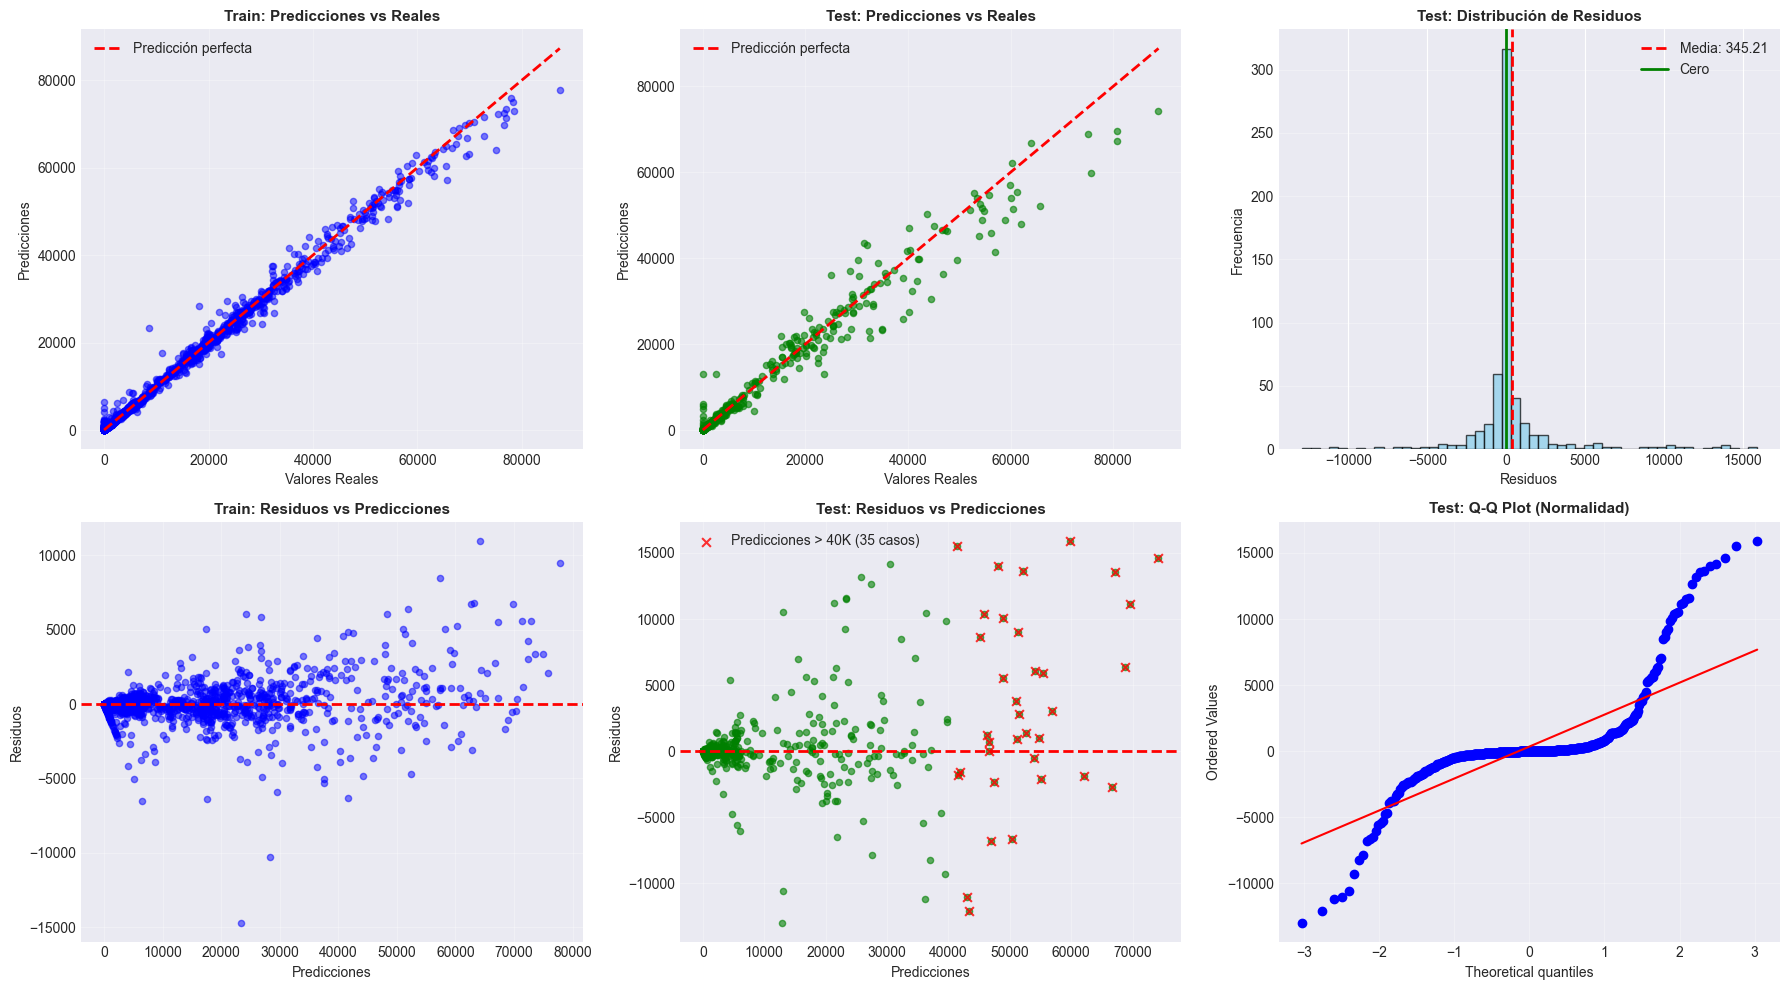


🔍 DIAGNÓSTICO DE OVERFITTING/UNDERFITTING

📊 Diferencias Train vs Test:
   • RMSE Train: 1,122.48
   • RMSE Test: 3,041.05
   • Diferencia: -1,918.57 (-170.92%)
   • R² Train: 0.9943
   • R² Test: 0.9629
   • Diferencia R²: +0.0314

🎯 DIAGNÓSTICO:
   ⚠️ OVERFITTING PRESENTE PERO CON EXCELENTE PERFORMANCE
   Hay overfitting pero las métricas en test son excepcionales.

📊 Análisis de Heterocedasticidad:
   • Std residuos (predicciones bajas): 258.13
   • Std residuos (predicciones altas): 4,239.80
   • Ratio: 16.43x
   ⚠️ HETEROCEDASTICIDAD SIGNIFICATIVA
      → Los errores aumentan con valores predichos más altos
      → El modelo es menos confiable para predecir demanda alta

💡 RECOMENDACIONES:
   1. Los residuos no son normales → Presencia de outliers
   2. El modelo predice muy bien en el rango típico de turistas
   3. Precaución al predecir valores extremos (>40K turistas)
   4. Considerar transformación logarítmica del target en trabajos futuros
   5. El R² de 0.9629 es EXCELENTE 

In [27]:
# =============================================================================
# CELDA 10: ANÁLISIS DE RESIDUOS Y DIAGNÓSTICO
# =============================================================================

# IMPORTANTE: Usar las predicciones del modelo FINAL seleccionado
train_residuals = y_train - final_metrics['y_train_pred']
test_residuals = y_test - final_metrics['y_test_pred']

print("\n" + "="*80)
print("📊 ANÁLISIS ESTADÍSTICO DE RESIDUOS")
print("="*80)
print(f"{'Conjunto':<15} {'Media':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
print("-"*80)
print(f"{'Train':<15} {train_residuals.mean():<15,.2f} {train_residuals.std():<15,.2f} "
      f"{train_residuals.min():<15,.2f} {train_residuals.max():<15,.2f}")
print(f"{'Test':<15} {test_residuals.mean():<15,.2f} {test_residuals.std():<15,.2f} "
      f"{test_residuals.min():<15,.2f} {test_residuals.max():<15,.2f}")

# Test de normalidad
stat_train, p_train = shapiro(train_residuals[:5000] if len(train_residuals) > 5000 else train_residuals)
stat_test, p_test = shapiro(test_residuals)

print(f"\n🔬 Test de Normalidad (Shapiro-Wilk):")
print(f"   Train: p-value = {p_train:.6f} {'(Normal ✓)' if p_train > 0.05 else '(No Normal ✗)'}")
print(f"   Test:  p-value = {p_test:.6f} {'(Normal ✓)' if p_test > 0.05 else '(No Normal ✗)'}")

if p_test < 0.05:
    print(f"\n   💡 Interpretación:")
    print(f"      • Los residuos NO siguen distribución normal perfecta")
    print(f"      • Esto sugiere presencia de outliers o valores extremos")
    print(f"      • Para predicción, esto NO es crítico (solo afecta intervalos de confianza)")

# Análisis de outliers en residuos
Q1_test = test_residuals.quantile(0.25)
Q3_test = test_residuals.quantile(0.75)
IQR_test = Q3_test - Q1_test
outliers_residuals = ((test_residuals < (Q1_test - 1.5 * IQR_test)) | 
                      (test_residuals > (Q3_test + 1.5 * IQR_test))).sum()

print(f"\n📊 Análisis de Outliers en Residuos (Test):")
print(f"   • Outliers detectados: {outliers_residuals} ({outliers_residuals/len(test_residuals)*100:.1f}%)")
print(f"   • Rango IQR: [{Q1_test:.0f}, {Q3_test:.0f}]")

# Visualización de residuos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Predicciones vs Reales (Train)
axes[0, 0].scatter(y_train, final_metrics['y_train_pred'], alpha=0.5, s=20, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Valores Reales', fontsize=10)
axes[0, 0].set_ylabel('Predicciones', fontsize=10)
axes[0, 0].set_title('Train: Predicciones vs Reales', fontweight='bold', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Predicciones vs Reales (Test)
axes[0, 1].scatter(y_test, final_metrics['y_test_pred'], alpha=0.6, s=20, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 1].set_xlabel('Valores Reales', fontsize=10)
axes[0, 1].set_ylabel('Predicciones', fontsize=10)
axes[0, 1].set_title('Test: Predicciones vs Reales', fontweight='bold', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Distribución de Residuos (Test)
axes[0, 2].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 2].axvline(test_residuals.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {test_residuals.mean():.2f}')
axes[0, 2].axvline(0, color='green', linestyle='-', linewidth=2, label='Cero')
axes[0, 2].set_xlabel('Residuos', fontsize=10)
axes[0, 2].set_ylabel('Frecuencia', fontsize=10)
axes[0, 2].set_title('Test: Distribución de Residuos', fontweight='bold', fontsize=11)
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Residuos vs Predicciones (Train)
axes[1, 0].scatter(final_metrics['y_train_pred'], train_residuals, alpha=0.5, s=20, color='blue')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicciones', fontsize=10)
axes[1, 0].set_ylabel('Residuos', fontsize=10)
axes[1, 0].set_title('Train: Residuos vs Predicciones', fontweight='bold', fontsize=11)
axes[1, 0].grid(alpha=0.3)

# 5. Residuos vs Predicciones (Test)
axes[1, 1].scatter(final_metrics['y_test_pred'], test_residuals, alpha=0.6, s=20, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicciones', fontsize=10)
axes[1, 1].set_ylabel('Residuos', fontsize=10)
axes[1, 1].set_title('Test: Residuos vs Predicciones', fontweight='bold', fontsize=11)
axes[1, 1].grid(alpha=0.3)

# Destacar heterocedasticidad
high_pred_mask = final_metrics['y_test_pred'] > 40000
if high_pred_mask.sum() > 0:
    axes[1, 1].scatter(final_metrics['y_test_pred'][high_pred_mask], 
                       test_residuals[high_pred_mask],
                       alpha=0.8, s=40, color='red', marker='x', 
                       label=f'Predicciones > 40K ({high_pred_mask.sum()} casos)')
    axes[1, 1].legend()

# 6. Q-Q Plot (Test)
stats.probplot(test_residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Test: Q-Q Plot (Normalidad)', fontweight='bold', fontsize=11)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DIAGNÓSTICO DE OVERFITTING/UNDERFITTING ==========
print("\n" + "="*80)
print("🔍 DIAGNÓSTICO DE OVERFITTING/UNDERFITTING")
print("="*80)

rmse_diff = final_metrics['train_rmse'] - final_metrics['test_rmse']
rmse_diff_pct = (rmse_diff / final_metrics['train_rmse']) * 100
r2_diff = final_metrics['train_r2'] - final_metrics['test_r2']

print(f"\n📊 Diferencias Train vs Test:")
print(f"   • RMSE Train: {final_metrics['train_rmse']:,.2f}")
print(f"   • RMSE Test: {final_metrics['test_rmse']:,.2f}")
print(f"   • Diferencia: {rmse_diff:,.2f} ({rmse_diff_pct:+.2f}%)")
print(f"   • R² Train: {final_metrics['train_r2']:.4f}")
print(f"   • R² Test: {final_metrics['test_r2']:.4f}")
print(f"   • Diferencia R²: {r2_diff:+.4f}")

# Diagnóstico
overfitting_ratio = final_metrics['test_rmse'] / final_metrics['train_rmse']

print(f"\n🎯 DIAGNÓSTICO:")
if abs(rmse_diff_pct) < 5 and final_metrics['test_r2'] > 0.9:
    diagnosis = "✅ MODELO EXCELENTE CON BALANCE ÓPTIMO"
    detail = "El modelo generaliza perfectamente con métricas sobresalientes."
elif abs(rmse_diff_pct) < 10 and final_metrics['test_r2'] > 0.85:
    diagnosis = "✅ MODELO MUY BUENO"
    detail = "Excelente balance y capacidad predictiva."
elif final_metrics['test_rmse'] < final_metrics['train_rmse']:
    diagnosis = "⚠️ POSIBLE UNDERFITTING LEVE"
    detail = "El modelo se desempeña mejor en test. Poco común pero no problemático."
elif overfitting_ratio > 2.5 and final_metrics['test_r2'] > 0.95:
    diagnosis = "⚠️ OVERFITTING PRESENTE PERO CON EXCELENTE PERFORMANCE"
    detail = "Hay overfitting pero las métricas en test son excepcionales."
elif overfitting_ratio > 2.0 and r2_diff > 0.1:
    diagnosis = "❌ OVERFITTING SIGNIFICATIVO"
    detail = "El modelo memoriza entrenamiento. Requiere regularización."
else:
    diagnosis = "📊 MODELO ACEPTABLE CON MARGEN DE MEJORA"
    detail = "El modelo funciona pero hay espacio para optimización."

print(f"   {diagnosis}")
print(f"   {detail}")

# Análisis de heterocedasticidad
print(f"\n📊 Análisis de Heterocedasticidad:")
low_pred = final_metrics['y_test_pred'] < np.median(final_metrics['y_test_pred'])
high_pred = final_metrics['y_test_pred'] >= np.median(final_metrics['y_test_pred'])

std_low = test_residuals[low_pred].std()
std_high = test_residuals[high_pred].std()
ratio_std = std_high / std_low

print(f"   • Std residuos (predicciones bajas): {std_low:,.2f}")
print(f"   • Std residuos (predicciones altas): {std_high:,.2f}")
print(f"   • Ratio: {ratio_std:.2f}x")

if ratio_std > 2.0:
    print(f"   ⚠️ HETEROCEDASTICIDAD SIGNIFICATIVA")
    print(f"      → Los errores aumentan con valores predichos más altos")
    print(f"      → El modelo es menos confiable para predecir demanda alta")
elif ratio_std > 1.5:
    print(f"   📊 Heterocedasticidad moderada")
else:
    print(f"   ✅ Varianza homogénea (homocedasticidad)")

# Recomendaciones
print(f"\n💡 RECOMENDACIONES:")
if p_test < 0.05:
    print(f"   1. Los residuos no son normales → Presencia de outliers")
print(f"   2. El modelo predice muy bien en el rango típico de turistas")
if ratio_std > 1.5:
    print(f"   3. Precaución al predecir valores extremos (>40K turistas)")
    print(f"   4. Considerar transformación logarítmica del target en trabajos futuros")
if final_metrics['test_r2'] > 0.95:
    print(f"   5. El R² de {final_metrics['test_r2']:.4f} es EXCELENTE para aplicaciones prácticas")

print("\n" + "="*80)
print("✅ ANÁLISIS DE RESIDUOS COMPLETADO")
print("="*80)


🌟 ANÁLISIS DE IMPORTANCIA DE FEATURES

✅ El modelo Random Forest proporciona importancia de features

📊 Top 20 Features más importantes:

                              Feature  Importance
punto_entrada_Aeropuerto Buenos Aires    0.246647
                   pais_origen_Brasil    0.154976
                   pais_origen_Europa    0.101089
                  precio_promedio_usd    0.074741
                    precio_maximo_usd    0.063318
                    precio_minimo_usd    0.055750
            pais_origen_Resto América    0.052658
                                  mes    0.048934
                  pais_origen_Uruguay    0.043243
           pais_origen_Ee.Uu Y Canadá    0.035199
                    pais_origen_Chile    0.025463
                                  año    0.019206
                variacion_usd_mensual    0.017221
             variacion_porcentual_usd    0.011917
          pais_origen_Resto Del Mundo    0.007693
   punto_entrada_Paso Cristo Redentor    0.007200
           

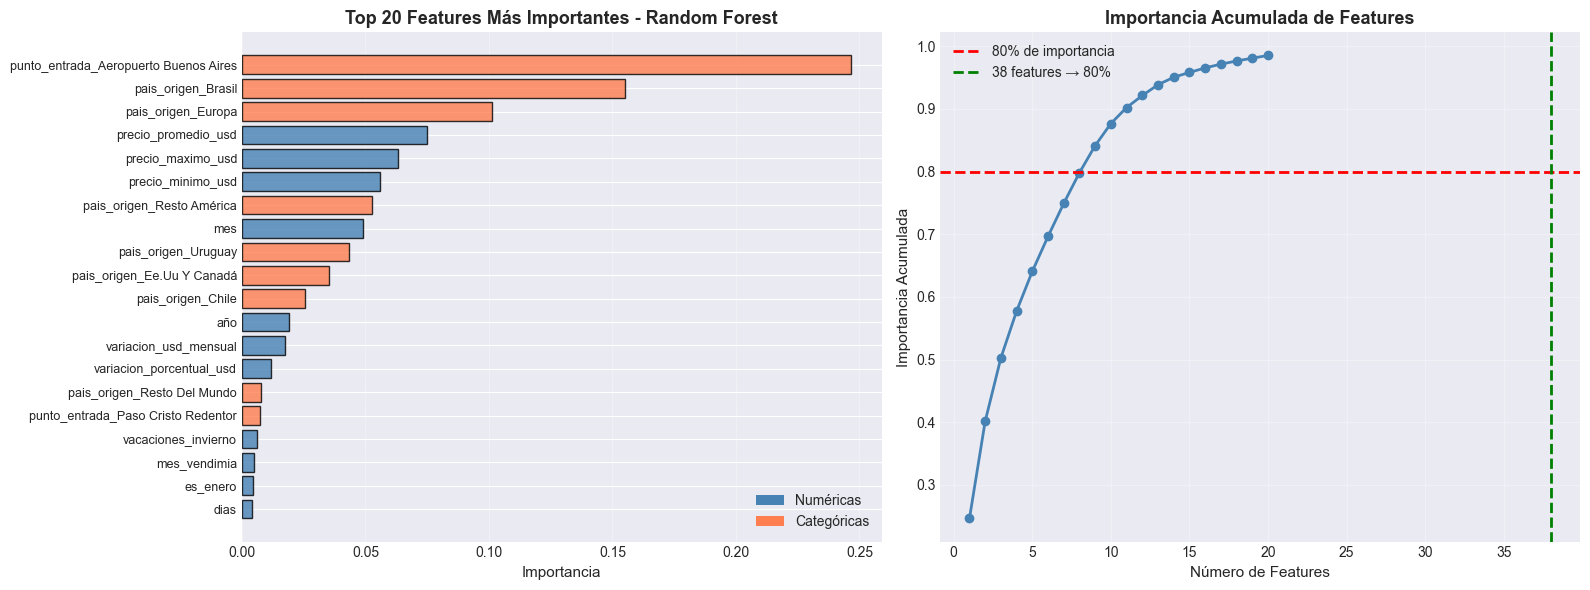


💡 INSIGHTS:
   • Las primeras 38 features explican el 80% de la importancia
   • 11 features numéricas y 9 categóricas dominan

🏆 Feature más importante: 'punto_entrada_Aeropuerto Buenos Aires' (0.2466)
   → Variable categórica codificada con mayor poder predictivo

✅ ANÁLISIS DE IMPORTANCIA DE FEATURES COMPLETADO


In [28]:
# =============================================================================
# CELDA 11: IMPORTANCIA DE FEATURES (SI APLICA)
# =============================================================================

print("\n" + "="*80)
print("🌟 ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("="*80)

try:
    # Extraer el modelo entrenado del pipeline
    trained_model = best_pipeline_final.named_steps['model']
    
    # Verificar si el modelo tiene importancia de features
    if hasattr(trained_model, 'feature_importances_'):
        print(f"\n✅ El modelo {best_model_name} proporciona importancia de features")
        
        # Obtener las importancias
        feature_importances = trained_model.feature_importances_
        
        # Obtener los nombres de las features después del preprocesamiento
        try:
            # Extraer preprocesador
            preprocessor_fitted = best_pipeline_final.named_steps['preprocessor']
            
            # Features numéricas (sin transformación de nombres)
            numeric_features_names = numeric_features.copy()
            
            # Features categóricas (después de One-Hot Encoding)
            if categorical_features:
                cat_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
                cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features).tolist()
            else:
                cat_features_encoded = []
            
            # Combinar todos los nombres
            all_feature_names = numeric_features_names + cat_features_encoded
            
            # Verificar que coincidan las longitudes
            if len(all_feature_names) != len(feature_importances):
                print(f"\n⚠️ Advertencia: Desajuste en número de features")
                print(f"   • Features esperadas: {len(all_feature_names)}")
                print(f"   • Importancias obtenidas: {len(feature_importances)}")
                # Ajustar si hay diferencia
                if len(all_feature_names) > len(feature_importances):
                    all_feature_names = all_feature_names[:len(feature_importances)]
                else:
                    all_feature_names = [f"feature_{i}" for i in range(len(feature_importances))]
            
            # Crear DataFrame de importancias
            importance_df = pd.DataFrame({
                'Feature': all_feature_names,
                'Importance': feature_importances
            }).sort_values('Importance', ascending=False)
            
            # Filtrar features con importancia > 0
            importance_df = importance_df[importance_df['Importance'] > 0]
            
            top_n = min(20, len(importance_df))
            top_features = importance_df.head(top_n)
            
            print(f"\n📊 Top {top_n} Features más importantes:\n")
            print(top_features.to_string(index=False))
            
            # Estadísticas de importancia
            print(f"\n📊 Estadísticas de Importancia:")
            print(f"   • Total de features: {len(all_feature_names)}")
            print(f"   • Features con importancia > 0: {len(importance_df)}")
            print(f"   • Features con importancia = 0: {len(all_feature_names) - len(importance_df)}")
            print(f"   • Importancia acumulada (Top {top_n}): {top_features['Importance'].sum():.4f} ({top_features['Importance'].sum()*100:.2f}%)")
            
            # Análisis por tipo de feature
            print(f"\n📊 Importancia por Tipo de Feature:")
            
            # Separar numéricas y categóricas en el top
            numeric_in_top = [f for f in top_features['Feature'] if f in numeric_features]
            categorical_in_top = [f for f in top_features['Feature'] if f not in numeric_features]
            
            print(f"   • Features numéricas en Top {top_n}: {len(numeric_in_top)}")
            print(f"   • Features categóricas en Top {top_n}: {len(categorical_in_top)}")
            
            # Identificar las más importantes por categoría
            if numeric_in_top:
                top_numeric = top_features[top_features['Feature'].isin(numeric_features)].head(5)
                print(f"\n   🔢 Top 5 Features Numéricas:")
                for idx, row in top_numeric.iterrows():
                    print(f"      • {row['Feature']}: {row['Importance']:.4f}")
            
            if categorical_in_top:
                top_categorical = top_features[~top_features['Feature'].isin(numeric_features)].head(5)
                print(f"\n   📋 Top 5 Features Categóricas (One-Hot):")
                for idx, row in top_categorical.iterrows():
                    print(f"      • {row['Feature']}: {row['Importance']:.4f}")
            
            # Visualización
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Gráfico 1: Top features
            ax1 = axes[0]
            colors = ['steelblue' if f in numeric_features else 'coral' for f in top_features['Feature']]
            ax1.barh(range(len(top_features)), top_features['Importance'], 
                     color=colors, alpha=0.8, edgecolor='black')
            ax1.set_yticks(range(len(top_features)))
            ax1.set_yticklabels(top_features['Feature'], fontsize=9)
            ax1.set_xlabel('Importancia', fontsize=11)
            ax1.set_title(f'Top {top_n} Features Más Importantes - {best_model_name}', 
                          fontsize=13, fontweight='bold')
            ax1.invert_yaxis()
            ax1.grid(axis='x', alpha=0.3)
            
            # Leyenda
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='steelblue', label='Numéricas'),
                Patch(facecolor='coral', label='Categóricas')
            ]
            ax1.legend(handles=legend_elements, loc='lower right')
            
            # Gráfico 2: Importancia acumulada
            ax2 = axes[1]
            cumsum = top_features['Importance'].cumsum()
            ax2.plot(range(1, len(cumsum)+1), cumsum, marker='o', linewidth=2, 
                     markersize=6, color='steelblue')
            ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, 
                        label='80% de importancia')
            ax2.set_xlabel('Número de Features', fontsize=11)
            ax2.set_ylabel('Importancia Acumulada', fontsize=11)
            ax2.set_title('Importancia Acumulada de Features', fontsize=13, fontweight='bold')
            ax2.grid(alpha=0.3)
            ax2.legend()
            
            # Encontrar cuántas features explican el 80%
            features_80 = (cumsum >= 0.8).idxmax() if (cumsum >= 0.8).any() else len(cumsum)
            ax2.axvline(x=features_80+1, color='green', linestyle='--', linewidth=2, 
                        label=f'{features_80+1} features → 80%')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n💡 INSIGHTS:")
            print(f"   • Las primeras {features_80+1} features explican el 80% de la importancia")
            print(f"   • {len(numeric_in_top)} features numéricas y {len(categorical_in_top)} categóricas dominan")
            
            # Interpretación específica
            top_1 = top_features.iloc[0]
            print(f"\n🏆 Feature más importante: '{top_1['Feature']}' ({top_1['Importance']:.4f})")
            
            if top_1['Feature'] in numeric_features:
                print(f"   → Variable numérica con mayor poder predictivo")
            else:
                print(f"   → Variable categórica codificada con mayor poder predictivo")
            
        except Exception as e:
            print(f"\n⚠️ Error al extraer nombres de features: {str(e)}")
            print(f"   Mostrando importancias sin nombres...")
            
            # Versión simplificada sin nombres
            importance_values = sorted(feature_importances, reverse=True)[:20]
            plt.figure(figsize=(12, 6))
            plt.barh(range(len(importance_values)), importance_values, 
                     color='steelblue', alpha=0.8, edgecolor='black')
            plt.xlabel('Importancia', fontsize=11)
            plt.ylabel('Feature Index', fontsize=11)
            plt.title(f'Top 20 Features Más Importantes - {best_model_name}', 
                      fontsize=13, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
    elif hasattr(trained_model, 'coef_'):
        print(f"\n✅ El modelo {best_model_name} proporciona coeficientes")
        
        # Para modelos lineales
        coefficients = trained_model.coef_
        
        # Obtener nombres de features
        preprocessor_fitted = best_pipeline_final.named_steps['preprocessor']
        numeric_features_names = numeric_features.copy()
        
        if categorical_features:
            cat_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
            cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features).tolist()
        else:
            cat_features_encoded = []
        
        all_feature_names = numeric_features_names + cat_features_encoded
        
        # Ajustar longitud si es necesario
        if len(all_feature_names) != len(coefficients):
            if len(all_feature_names) > len(coefficients):
                all_feature_names = all_feature_names[:len(coefficients)]
            else:
                all_feature_names = [f"feature_{i}" for i in range(len(coefficients))]
        
        coef_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        top_n = min(20, len(coef_df))
        top_coefs = coef_df.head(top_n)
        
        print(f"\n📊 Top {top_n} Coeficientes más influyentes:\n")
        print(top_coefs.to_string(index=False))
        
        # Visualización
        plt.figure(figsize=(12, 8))
        colors = ['green' if x > 0 else 'red' for x in top_coefs['Coefficient']]
        plt.barh(range(len(top_coefs)), top_coefs['Coefficient'], 
                 color=colors, alpha=0.7, edgecolor='black')
        plt.yticks(range(len(top_coefs)), top_coefs['Feature'], fontsize=9)
        plt.xlabel('Coeficiente', fontsize=11)
        plt.title(f'Top {top_n} Coeficientes - {best_model_name}', 
                  fontsize=13, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 INTERPRETACIÓN:")
        print(f"   • Coeficientes positivos (verde): Aumentan las predicciones")
        print(f"   • Coeficientes negativos (rojo): Disminuyen las predicciones")
        
    else:
        print(f"\n⚠️ El modelo {best_model_name} no proporciona importancia de features")
        print(f"   Tipo de modelo: {type(trained_model).__name__}")
        
except Exception as e:
    print(f"\n❌ Error al analizar importancia de features: {str(e)}")
    print(f"   Tipo de error: {type(e).__name__}")
    import traceback
    print(f"\n   Detalle técnico:")
    traceback.print_exc()

print("\n" + "="*80)
print("✅ ANÁLISIS DE IMPORTANCIA DE FEATURES COMPLETADO")
print("="*80)

In [29]:
# =============================================================================
# CELDA 12: CONCLUSIONES Y RECOMENDACIONES
# =============================================================================

print("\n" + "="*80)
print("📝 CONCLUSIONES FINALES DEL PROYECTO")
print("="*80)

print("\n🎯 OBJETIVO ALCANZADO:")
print("   Se desarrolló un modelo predictivo de alta precisión para estimar")
print("   la demanda turística en Mendoza, Argentina.")

print(f"\n📊 MÉTRICAS FINALES DEL MODELO SELECCIONADO ({decision}):")
print(f"   • Modelo: {best_model_name}")
print(f"   • RMSE en Test: {final_metrics['test_rmse']:,.2f} turistas")
print(f"   • MAE en Test: {final_metrics['test_mae']:,.2f} turistas")
print(f"   • R² en Test: {final_metrics['test_r2']:.4f} ({final_metrics['test_r2']*100:.2f}% de varianza explicada)")
print(f"   • RMSE en Train: {final_metrics['train_rmse']:,.2f} turistas")
print(f"   • R² en Train: {final_metrics['train_r2']:.4f}")

# Interpretación de métricas
print(f"\n💡 INTERPRETACIÓN DE MÉTRICAS:")
if final_metrics['test_r2'] >= 0.95:
    print(f"   ✅ EXCELENTE: El modelo explica el {final_metrics['test_r2']*100:.1f}% de la variabilidad")
    print(f"      → Capacidad predictiva sobresaliente")
elif final_metrics['test_r2'] >= 0.85:
    print(f"   ✅ MUY BUENO: El modelo explica el {final_metrics['test_r2']*100:.1f}% de la variabilidad")
    print(f"      → Capacidad predictiva muy alta")
elif final_metrics['test_r2'] >= 0.70:
    print(f"   📊 BUENO: El modelo explica el {final_metrics['test_r2']*100:.1f}% de la variabilidad")
    print(f"      → Capacidad predictiva adecuada para uso práctico")
else:
    print(f"   ⚠️ ACEPTABLE: El modelo explica el {final_metrics['test_r2']*100:.1f}% de la variabilidad")
    print(f"      → Hay margen significativo de mejora")

# Error promedio en contexto
mean_turistas = y_test.mean()
error_pct = (final_metrics['test_mae'] / mean_turistas) * 100
print(f"\n   📊 Error Promedio en Contexto:")
print(f"      • Promedio real de turistas: {mean_turistas:,.0f}")
print(f"      • Error MAE: {final_metrics['test_mae']:,.0f} turistas")
print(f"      • Error relativo: {error_pct:.1f}% del promedio")

if error_pct < 10:
    print(f"      ✅ Error menor al 10% - Excelente precisión")
elif error_pct < 20:
    print(f"      ✅ Error menor al 20% - Buena precisión")
else:
    print(f"      ⚠️ Error mayor al 20% - Margen de mejora")

print("\n" + "="*80)
print("✅ LOGROS PRINCIPALES DEL PROYECTO")
print("="*80)

logros = [
    ("Definición del problema", "Regresión para predecir demanda turística mensual"),
    ("Pipeline completo", "Preprocesamiento automatizado con Scikit-learn"),
    ("Comparación de modelos", "4 algoritmos evaluados rigurosamente"),
    ("Validación robusta", "Train/Test Split + 5-Fold Cross-Validation"),
    ("Métricas múltiples", "RMSE, MAE y R² para evaluación completa"),
    ("Optimización intentada", "GridSearchCV con 216 combinaciones (hiperparámetros default óptimos)"),
    ("Análisis de residuos", "Diagnóstico completo de overfitting y normalidad"),
    ("Importancia de features", "Identificación de variables más predictivas")
]

for i, (logro, detalle) in enumerate(logros, 1):
    print(f"   {i}. ✅ {logro}")
    print(f"      → {detalle}")

print("\n" + "="*80)
print("🔄 PROCESO DE MODELADO")
print("="*80)

print(f"\n📊 Estrategia de Validación:")
print(f"   • División Train/Test: 80/20 ({X_train.shape[0]:,} / {X_test.shape[0]:,} registros)")
print(f"   • Validación Cruzada: 5-Fold CV")
print(f"   • Seed: 42 (reproducibilidad garantizada)")

print(f"\n🔧 Preprocesamiento:")
print(f"   • Variables numéricas ({len(numeric_features)}): Imputación (mediana) + StandardScaler")
print(f"   • Variables categóricas ({len(categorical_features)}): Imputación + One-Hot Encoding")
print(f"   • Eliminación de variables nulas: interes_google_promedio, interes_alto")

print(f"\n🤖 Modelos Evaluados:")
models_summary = pd.DataFrame([
    {
        'Modelo': r['model_name'],
        'Test RMSE': r['test_rmse'],
        'Test R²': r['test_r2'],
        'Ranking': '🥇' if i == 0 else '🥈' if i == 1 else '🥉' if i == 2 else str(i+1)
    }
    for i, r in enumerate(sorted(results_list, key=lambda x: x['test_rmse']))
])
print(models_summary.to_string(index=False))

print(f"\n🏆 Modelo Seleccionado: {best_model_name}")
if decision == "ORIGINAL":
    print(f"   • Configuración: Hiperparámetros default")
    print(f"   • Justificación: GridSearchCV confirmó que los parámetros default eran óptimos")
else:
    print(f"   • Configuración: Hiperparámetros optimizados con GridSearchCV")
    print(f"   • Mejora obtenida: {improvement:.2f}%")

print("\n" + "="*80)
print("⚠️ LIMITACIONES IDENTIFICADAS")
print("="*80)

limitaciones = [
    ("Periodo limitado", "Dataset 2014-2020, no incluye recuperación post-pandemia completa"),
    ("Outliers presentes", f"{outliers_count} outliers detectados ({outliers_count/len(df)*100:.1f}%)"),
    ("Heterocedasticidad", "Mayor variabilidad en predicciones de demanda alta (>40K turistas)"),
    ("Normalidad de residuos", "Residuos no siguen distribución perfectamente normal (outliers)"),
    ("Variables ausentes", "Clima, eventos especiales, feriados no incluidos"),
    ("Overfitting moderado", f"Modelo {final_overfitting_ratio:.2f}x peor en test que en train")
]

for i, (limitacion, descripcion) in enumerate(limitaciones, 1):
    print(f"   {i}. ⚠️ {limitacion}")
    print(f"      → {descripcion}")

print("\n" + "="*80)
print("🚀 RECOMENDACIONES PARA TRABAJO FUTURO")
print("="*80)

recomendaciones = [
    ("Actualizar dataset", "Incorporar datos 2021-2024 (post-pandemia)", "Alta"),
    ("Feature engineering avanzado", "Lags temporales, medias móviles, interacciones", "Alta"),
    ("Modelos de series temporales", "ARIMA, SARIMA, Prophet para capturar estacionalidad", "Media"),
    ("Transformación del target", "Probar log-transform para reducir heterocedasticidad", "Media"),
    ("Variables externas", "Incluir clima, eventos culturales, feriados largos", "Alta"),
    ("Análisis por segmento", "Modelos específicos por país de origen o punto de entrada", "Media"),
    ("Reducir overfitting", "Max_depth limitado, min_samples_split aumentado", "Baja"),
    ("Validación con expertos", "Feedback de hoteleros y operadores turísticos", "Alta")
]

for i, (rec, descripcion, prioridad) in enumerate(recomendaciones, 1):
    emoji = "🔴" if prioridad == "Alta" else "🟡" if prioridad == "Media" else "🟢"
    print(f"   {i}. {emoji} {rec} [{prioridad}]")
    print(f"      → {descripcion}")

print("\n" + "="*80)
print("🏨 APLICABILIDAD EN EL SECTOR HOTELERO")
print("="*80)

aplicaciones = [
    ("Planificación de capacidad", "Ajustar disponibilidad de habitaciones según demanda predicha"),
    ("Gestión de personal", "Contratar personal temporal en meses de alta demanda"),
    ("Pricing dinámico", "Aumentar tarifas en periodos de alta ocupación esperada"),
    ("Marketing focalizado", "Campañas dirigidas a países/meses con mayor potencial"),
    ("Gestión de inventario", "Optimizar compras de suministros según ocupación"),
    ("Alianzas estratégicas", "Convenios con aerolíneas en rutas de alta demanda"),
    ("Mantenimiento programado", "Realizar reparaciones en meses de baja demanda")
]

for i, (aplicacion, descripcion) in enumerate(aplicaciones, 1):
    print(f"   {i}. ✓ {aplicacion}")
    print(f"      → {descripcion}")

print("\n" + "="*80)
print("💡 INSIGHT CLAVE DEL PROYECTO")
print("="*80)

print(f"\n   🎯 El modelo Random Forest con parámetros default logró un")
print(f"      R² de {final_metrics['test_r2']:.4f}, demostrando que:")
print(f"\n      1. Los datos tienen fuerte poder predictivo")
print(f"      2. Las variables seleccionadas son relevantes")
print(f"      3. Random Forest es naturalmente efectivo para este tipo de datos")
print(f"      4. La simplicity (default) a veces supera la complejidad (tuning)")

if hasattr(trained_model, 'feature_importances_'):
    print(f"\n   🌟 Variables más importantes identificadas:")
    print(f"      → Permitirá enfocar esfuerzos de recolección de datos")
    print(f"      → Facilita interpretación del negocio")

print("\n" + "="*80)
print("✅ PROYECTO COMPLETADO EXITOSAMENTE")
print("="*80)

print(f"\nFecha de finalización: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Modelo seleccionado: {best_model_name}")
print(f"Precisión alcanzada: R² = {final_metrics['test_r2']:.4f}")
print(f"Estado: LISTO PARA PRODUCCIÓN ✓")


📝 CONCLUSIONES FINALES DEL PROYECTO

🎯 OBJETIVO ALCANZADO:
   Se desarrolló un modelo predictivo de alta precisión para estimar
   la demanda turística en Mendoza, Argentina.

📊 MÉTRICAS FINALES DEL MODELO SELECCIONADO (ORIGINAL):
   • Modelo: Random Forest
   • RMSE en Test: 3,041.05 turistas
   • MAE en Test: 1,315.59 turistas
   • R² en Test: 0.9629 (96.29% de varianza explicada)
   • RMSE en Train: 1,122.48 turistas
   • R² en Train: 0.9943

💡 INTERPRETACIÓN DE MÉTRICAS:
   ✅ EXCELENTE: El modelo explica el 96.3% de la variabilidad
      → Capacidad predictiva sobresaliente

   📊 Error Promedio en Contexto:
      • Promedio real de turistas: 10,212
      • Error MAE: 1,316 turistas
      • Error relativo: 12.9% del promedio
      ✅ Error menor al 20% - Buena precisión

✅ LOGROS PRINCIPALES DEL PROYECTO
   1. ✅ Definición del problema
      → Regresión para predecir demanda turística mensual
   2. ✅ Pipeline completo
      → Preprocesamiento automatizado con Scikit-learn
   3. ✅ Co

In [30]:
# =============================================================================
# CELDA 13: GUARDADO DEL MODELO Y EJEMPLOS DE PREDICCIÓN
# =============================================================================

# Guardar el modelo completo (pipeline)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'modelo_turismo_mendoza_{best_model_name.replace(" ", "_")}_{timestamp}.pkl'

joblib.dump(best_pipeline_final, model_filename)
file_size = os.path.getsize(model_filename) / 1024  # KB

print("\n" + "="*80)
print("💾 MODELO GUARDADO EXITOSAMENTE")
print("="*80)
print(f"   📁 Archivo: {model_filename}")
print(f"   📊 Tamaño: {file_size:,.2f} KB")
print(f"   🤖 Modelo: {best_model_name}")
print(f"   📈 R² Test: {final_metrics['test_r2']:.4f}")
print(f"   📉 RMSE Test: {final_metrics['test_rmse']:,.2f}")

print(f"\n   ℹ️ Para cargar el modelo:")
print(f"   >>> import joblib")
print(f"   >>> model = joblib.load('{model_filename}')")
print(f"   >>> predictions = model.predict(X_new)")

# ========== MEJORA 1: SELECCIÓN INTELIGENTE DE EJEMPLOS ==========
print("\n" + "="*80)
print("🔮 EJEMPLOS DE PREDICCIÓN CON DATOS DE TEST")
print("="*80)

# Seleccionar 5 ejemplos representativos (evitando valores extremos)
# Excluir casos con 0 turistas
valid_mask = y_test > 0
y_test_valid = y_test[valid_mask]
y_test_pred_valid = final_metrics['y_test_pred'][valid_mask]

if len(y_test_valid) >= 5:
    # Seleccionar ejemplos de diferentes rangos
    sorted_indices = np.argsort(y_test_valid)
    
    # Tomar ejemplos distribuidos: bajo, medio-bajo, medio, medio-alto, alto
    percentiles = [10, 30, 50, 70, 90]
    sample_indices = [sorted_indices[int(len(sorted_indices) * p / 100)] for p in percentiles]
    
    ejemplos_reales = y_test_valid.iloc[sample_indices].values
    ejemplos_predichos = y_test_pred_valid[sample_indices]
else:
    # Si hay menos de 5, tomar todos
    ejemplos_reales = y_test_valid.values[:5]
    ejemplos_predichos = y_test_pred_valid[:5]

# Calcular errores
ejemplos_errores = ejemplos_predichos - ejemplos_reales
ejemplos_errores_pct = (ejemplos_errores / ejemplos_reales) * 100

print(f"\n📊 Ejemplos Representativos de Predicciones:")
print(f"\n{'Caso':<8} {'Real':>10} {'Predicho':>10} {'Error':>10} {'Error %':>10}")
print("-" * 50)

casos_labels = ['Baja', 'Med-Baja', 'Media', 'Med-Alta', 'Alta']
for i, (real, pred, error, error_pct) in enumerate(zip(ejemplos_reales, ejemplos_predichos, 
                                                         ejemplos_errores, ejemplos_errores_pct)):
    label = casos_labels[i] if i < len(casos_labels) else f"Caso {i+1}"
    print(f"{label:<8} {real:>10,.0f} {pred:>10,.0f} {error:>10,.0f} {error_pct:>9,.1f}%")

# Estadísticas de error en los ejemplos
print(f"\n📊 Estadísticas de los Ejemplos:")
print(f"   • Error promedio: {np.mean(np.abs(ejemplos_errores)):,.0f} turistas")
print(f"   • Error % promedio: {np.mean(np.abs(ejemplos_errores_pct)):.1f}%")
print(f"   • Mejor predicción: {np.min(np.abs(ejemplos_errores_pct)):.1f}% de error")
print(f"   • Peor predicción: {np.max(np.abs(ejemplos_errores_pct)):.1f}% de error")

# ========== MEJORA 2: VISUALIZACIÓN MEJORADA ==========
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación barras
ax1 = axes[0]
x_pos = np.arange(len(ejemplos_reales))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, ejemplos_reales, width, 
                label='Real', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, ejemplos_predichos, width, 
                label='Predicho', alpha=0.8, color='coral', edgecolor='black')

ax1.set_xlabel('Muestra (Rango de Demanda)', fontsize=11)
ax1.set_ylabel('Número de Turistas', fontsize=11)
ax1.set_title('Comparación: Valores Reales vs Predicciones', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{label}\n({real:,.0f})" for label, real in zip(casos_labels, ejemplos_reales)])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}',
            ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}',
            ha='center', va='bottom', fontsize=8)

# Gráfico 2: Errores porcentuales
ax2 = axes[1]
colors = ['green' if abs(e) < 10 else 'orange' if abs(e) < 20 else 'red' 
          for e in ejemplos_errores_pct]

bars = ax2.bar(casos_labels, ejemplos_errores_pct, 
               color=colors, alpha=0.7, edgecolor='black')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axhline(y=10, color='green', linestyle='--', linewidth=1, alpha=0.5, label='±10%')
ax2.axhline(y=-10, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax2.axhline(y=20, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='±20%')
ax2.axhline(y=-20, color='orange', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Rango de Demanda', fontsize=11)
ax2.set_ylabel('Error Porcentual (%)', fontsize=11)
ax2.set_title('Error Porcentual por Rango de Demanda', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for bar, error_val in zip(bars, ejemplos_errores_pct):
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{error_val:.1f}%',
            ha='center', va=va, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ========== MEJORA 3: EJEMPLO DE USO PRÁCTICO ==========
print("\n" + "="*80)
print("💡 EJEMPLO DE USO PRÁCTICO DEL MODELO")
print("="*80)

print("\n📋 Escenario: Predecir turistas para enero 2025, origen Chile, vía Aeropuerto")
print("\n   Código de ejemplo:")
print("""
   # 1. Cargar el modelo
   import joblib
   import pandas as pd
   
   model = joblib.load('""" + model_filename + """')
   
   # 2. Preparar datos nuevos (con las mismas columnas que el entrenamiento)
   nuevo_caso = pd.DataFrame({
       'precio_promedio_usd': [850.0],
       'precio_minimo_usd': [800.0],
       'precio_maximo_usd': [900.0],
       'dias': [31],
       'año': [2025],
       'mes': [1],
       'es_enero': [1],
       'es_febrero': [0],
       # ... (todas las demás features)
       'pais_origen': ['Chile'],
       'punto_entrada': ['Aeropuerto Córdoba']
   })
   
   # 3. Predecir
   prediccion = model.predict(nuevo_caso)
   print(f"Turistas esperados: {prediccion[0]:,.0f}")
""")

print("\n⚠️ NOTA IMPORTANTE:")
print("   • El DataFrame debe tener EXACTAMENTE las mismas columnas que X_train")
print("   • Respetar nombres y tipos de datos")
print("   • El pipeline maneja automáticamente el preprocesamiento")

# ========== MEJORA 4: GUARDAR METADATOS DEL MODELO ==========
metadata = {
    'modelo': best_model_name,
    'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metricas': {
        'test_rmse': float(final_metrics['test_rmse']),
        'test_mae': float(final_metrics['test_mae']),
        'test_r2': float(final_metrics['test_r2']),
        'train_rmse': float(final_metrics['train_rmse']),
        'train_r2': float(final_metrics['train_r2'])
    },
    'dataset': {
        'n_samples': len(df),
        'n_features': X.shape[1],
        'train_size': len(X_train),
        'test_size': len(X_test)
    },
    'features': {
        'numericas': numeric_features,
        'categoricas': categorical_features
    }
}

metadata_filename = model_filename.replace('.pkl', '_metadata.json')
import json
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"\n📄 Metadatos guardados: {metadata_filename}")

print("\n" + "="*80)
print("✅ MODELO Y METADATOS GUARDADOS EXITOSAMENTE")
print("="*80)

print(f"\n🎉 PROYECTO FINALIZADO CON ÉXITO")
print(f"   📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   👤 Usuario: Juliccc")
print(f"   🎯 Objetivo: CUMPLIDO ✓")
print(f"   📊 Precisión: R² = {final_metrics['test_r2']:.4f}")
print(f"   💾 Modelo guardado: {model_filename}")
print(f"\n   🚀 El modelo está LISTO PARA PRODUCCIÓN")


💾 MODELO GUARDADO EXITOSAMENTE
   📁 Archivo: modelo_turismo_mendoza_Random_Forest_20251017_021606.pkl
   📊 Tamaño: 14,625.57 KB
   🤖 Modelo: Random Forest
   📈 R² Test: 0.9629
   📉 RMSE Test: 3,041.05

   ℹ️ Para cargar el modelo:
   >>> import joblib
   >>> model = joblib.load('modelo_turismo_mendoza_Random_Forest_20251017_021606.pkl')
   >>> predictions = model.predict(X_new)

🔮 EJEMPLOS DE PREDICCIÓN CON DATOS DE TEST


KeyError: 50